In [2]:
# Convert to python script, remember to delete/comment the next line in the actual file
# ! jupyter nbconvert --to python imageSegmentationWithBackground.ipynb --output testSamples26-7.py

[NbConvertApp] Converting notebook imageSegmentationWithBackground.ipynb to python
[NbConvertApp] Writing 66646 bytes to testSamples26-7.py


### # Imports

In [2]:
# Image reading and file handling 
import pandas as pd
import SimpleITK as sitk 
import os 
import shutil

# Image agumentaitons 
import numpy as np
import cv2

# import scipy

# Information saving
import pickle

# Train test set spliting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold

# Dataset building
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import random
from sklearn.model_selection import StratifiedKFold

# Model building
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim

# Evaluation metrics and Plotting
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [18]:
# ! pip freeze > requirements.txt
# ! pip uninstall -y -r requirements.txt

## Make a python environment
# ! python -m venv threeDresearchPip

## Download necessary packages 
# ! pip install matplotlib opencv-python scipy simpleitk pandas openpyxl scikit-learn nbconvert
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 

## May need to download networkx 3.1 because of older python version of torch
# ! pip install networkx==3.1

## For 3D image classification
# ! pip install foundation-cancer-image-biomarker -qq
# ! pip install foundation-cancer-image-biomarker
# ! pip3 install torchio

## In case pip breaks 
# ! python -m ensurepip --upgrade

## Check python version and packages
# ! python --version
# ! pip3 freeze > research3D.txt

## Get the data from the .xsxl file

In [3]:
columns = ['TAPS_CaseIDs_PreNAT','RECIST_PostNAT', 'Slice_Thickness']
data = pd.read_excel('PDAC-Response_working.xlsx', header=None,names = columns)
data.drop(0, inplace=True) # Remove the header row
data=data.sort_values(by=['TAPS_CaseIDs_PreNAT'])
# # Get the entire datasheet
cases = list(data['TAPS_CaseIDs_PreNAT'])
recistCriteria = list(data['RECIST_PostNAT'])

In [5]:
#Make the images aligned if not
#==========================================================================================
def makeAlign(image1,image2):
    image1.SetDirection(image2.GetDirection())
    image1.SetOrigin(image2.GetOrigin())
    image1.SetSpacing(image2.GetSpacing())
    return image1, image2

def isAligned(image1, image2):
    return image1.GetDirection() == image2.GetDirection() and image1.GetOrigin() == image2.GetOrigin() and image1.GetSpacing() == image2.GetSpacing()   

def resampleSizes(wholeHeader, segmentHeader):
    """ 
    Resamples the sitk image to have the same size based on the one with the largest size.
    """
    if wholeHeader.GetSize()[-1] >= segmentHeader.GetSize()[-1]:
        imageLarge = wholeHeader
        imageSmall = segmentHeader
        wholeThenSegmentOrder = True
    else:
        imageLarge = segmentHeader
        imageSmall = wholeHeader 
        wholeThenSegmentOrder = False

    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(imageLarge)  
    resample.SetInterpolator(sitk.sitkLinear)  # Choose the interpolation method (sitkLinear, sitkNearestNeighbor, etc.)
    resample.SetDefaultPixelValue(0)  # Set default pixel value for areas outside the original image

    imageSmall = resample.Execute(imageSmall)

    print(f'imageLarge: {imageLarge.GetSize()}')
    print(f'imageSmall: {imageSmall.GetSize()}')
    

    if wholeThenSegmentOrder:
        return imageLarge, imageSmall # whole, then segment
    else:
        return imageSmall, imageLarge # segment, then whole
    
def twoImageAlignProceess(wholeHeader,segmentHeader,verbose):    

    error = False
    # Check if the images are aligned
    wholeHeader, segmentHeader = makeAlign(wholeHeader, segmentHeader)
    imagesAreAligned = isAligned(wholeHeader, segmentHeader)
    print(f'Are the two images aligned now?: {imagesAreAligned}' if verbose==2 else '',end='')

    if not imagesAreAligned:
        error = True
        return None, None, True
    
    # Set the spacing of the image to 1x1x1mm voxel spacing
    wholeHeader.SetSpacing([1,1,1])
    segmentHeader.SetSpacing([1,1,1])
    imagesSpacingAligned = wholeHeader.GetSpacing() == segmentHeader.GetSpacing() 
    print(f'Are the two images aligned in terms of spacing?: {imagesSpacingAligned}' if verbose==2 else '',end='')

    if not imagesSpacingAligned:
        error = True
        return None, None, True
    
    imagesSizeAligned = wholeHeader.GetSize() == segmentHeader.GetSize() 
    print(f'Are the two images aligned in terms of size?: {imagesSizeAligned}' if verbose==2 else '',end='')

    if not imagesSizeAligned:
        wholeHeader, segmentHeader = resampleSizes(wholeHeader, segmentHeader)
        print(f'whole size: {wholeHeader.GetSize()}')
        print(f'segment size: {segmentHeader.GetSize()}')
        imagesSizeAligned = wholeHeader.GetSize() == segmentHeader.GetSize() 
        print(f'Are the two images aligned in terms of size now?: {imagesSizeAligned}' if verbose==2 else '',end='')
        if not imagesSizeAligned:
            error = True
            return None, None, True

    return wholeHeader, segmentHeader, False


In [4]:
# Image changing and conversion
#==========================================================================================

def window_image_to_adbomen(image, window_center, window_width):
    img_max = window_center + int(window_width / 2)
    img_min = window_center - int(window_width / 2)
    return np.clip(image, img_min, img_max)

def centerXYOfImage(overlay_mask, segment_mask, segmentedSlices, padding=10, scaledBoxes = None):
    """ 
    Centers the X and Y of the image to crop the image. segmentedSlices is given as an array of z-value slices because the same approach to x_indicies and y_indicies does not work on overlay_segment (works for x and y though)
    """
    _, x_indices, y_indices = np.where(segment_mask == 1)
    # Get the bounding box for x and y dimensions
    min_x, max_x = x_indices.min(), x_indices.max()
    min_y, max_y = y_indices.min(), y_indices.max()

    center_x = (min_x + max_x) // 2
    center_y = (min_y + max_y) // 2

    if scaledBoxes == None: # Define width and height in regards of the single image
        width = abs(max_x - min_x) // 2
        height = abs(max_y - min_y) // 2
    else:
        width = scaledBoxes[0]//2
        height = scaledBoxes[1]//2

    # Get the dimensions of the cropped image
    start_x = max(0, center_x - width - padding)
    end_x = min(segment_mask.shape[1], center_x + width + padding)
    start_y = max(0, center_y - height - padding)
    end_y = min(segment_mask.shape[2], center_y + height + padding)

    return overlay_mask[np.array(segmentedSlices), start_x:end_x, start_y:end_y]

def convertNdArrayToCV2Image(images, resolution = (64,64)):
    """ Converts a numpy array to a cv2 images"""
    # images = images.T
    if resolution == None:
        resolution = (64,64)#(64,64, len(images))

    images = images.T
    resizedImages = []
    print('\nImages Shape:', images.shape)
    print(f"Input array dtype: {images.dtype}")
    for idx in range(images.shape[-1]):
        try:
            image = images[:,:,idx]
            image = image.reshape((image.shape[0],image.shape[1])).astype('float32') #Need to convert to float to resize image
            resizedImages.append(cv2.resize(image, resolution, interpolation=cv2.INTER_LINEAR).astype('int32')) #Conver the image back to int32 after resizing
             
        except cv2.error as e:
            print(f"Error during resizing slice {idx}: {e}")

    resizedImages = np.array(resizedImages)
    print(f"Output array size after CV2: {resizedImages.shape}")
    return resizedImages


In [15]:
# Displaying segments
#==========================================================================================

def displayCroppedSegmentations(croppedSegment):
    print(f'CroppedSegment shape: {croppedSegment.shape}')
    # Display the segmented image slices 

    columnLen = 10
    rowLen = max(2,croppedSegment.shape[0] // columnLen + 1) 
    figure,axis = plt.subplots( rowLen, columnLen, figsize=(10, 10))
    
    rowIdx = 0
    for idx in range(croppedSegment.shape[0]):        
        if idx%columnLen == 0 and idx>0:
            rowIdx += 1        
        # axis[rowIdx][idx%columnLen].imshow(croppedSegment[idx,:,:] , cmap="gray", vmin = 40-(350)/2, vmax=40+(350)/2)
        axis[rowIdx][idx%columnLen].imshow(croppedSegment[idx,:,:] , cmap="gray")

        axis[rowIdx][idx%columnLen].axis('off')

    # Turn off the axis of the rest of the subplots
    for i in range(idx+1, rowLen*columnLen):
        if i%columnLen == 0:
            rowIdx += 1
        axis[rowIdx][i%columnLen].axis('off')
    
    plt.show()


def displayOverlayedSegmentations(segmentedSlices, augmented_whole, augmented_segment):
    # Display the segmented image slices 
    columnLen = 10
    rowLen = max(2,len(segmentedSlices) // columnLen + 1) 
    figure,axis = plt.subplots( rowLen, columnLen, figsize=(10, 10))
    rowIdx = 0
    for idx in range(len(segmentedSlices)):        
        if idx%columnLen == 0 and idx>0:
            rowIdx += 1
        axis[rowIdx][idx%columnLen].imshow(augmented_whole[segmentedSlices[idx],:,:], cmap="gray")
        axis[rowIdx][idx%columnLen].imshow(augmented_segment[segmentedSlices[idx],:,:], cmap="Blues", alpha=0.75)
        axis[rowIdx][idx%columnLen].axis('off')

    # Turn off the axis of the rest of the subplots
    for i in range(idx+1, rowLen*columnLen):
        if i%columnLen == 0:
            rowIdx += 1
        axis[rowIdx][i%columnLen].axis('off')
    plt.show()


In [6]:
# Getting optimal slice(s) to use
#==========================================================================================

def getLargestSlice(croppedSegment):
    """
    Finds the index with the largest slice in the croppedSegment and returns the index as well as the sorted number of slices each index has
    """
    max = 0
    maxIndex = 0
    
    indices = []
    sliceTotals = []
    for idx in range(croppedSegment.shape[0]):
        unique, counts = np.unique(croppedSegment[idx,:,:], return_counts=True)
        values = dict(zip(unique, counts))
        sliceTotal = 0
        for value,count in values.items():
            sliceTotal += count if value > 0 else 0 
        
        indices.append(idx)
        sliceTotals.append(sliceTotal)
        
        if sliceTotal > max: 
            max = sliceTotal
            maxIndex = idx 

    values = dict(zip(sliceTotals,indices))
    values = dict(sorted(values.items())) # Sort the values by number of slices

    return maxIndex, values

def updateSlices(croppedSegment, desiredNumberOfSlices=1):
    """
    Updates the number of slices to the number of slices given. 
    If the numberOfSlices > the number of slices in the croppedSegment, it will duplicate the slices of the largest slices 
    If the numberOfSlices < the number of slices in the croppedSegment, it will remove the slices with the least amount of information 
    If the numberOfSlices == the number of slices in the croppedSegment, it will do nothing     
    """
    print('desiredNumberOfSlices',desiredNumberOfSlices)
    if croppedSegment.shape[0] == desiredNumberOfSlices:
        return croppedSegment
    elif croppedSegment.shape[0] < desiredNumberOfSlices: # Duplicate slices from the largest slice

        # Specifications of croppedSegment
        original = np.copy(croppedSegment)
        largestSliceIndex, _ = getLargestSlice(croppedSegment)
        maxUpperBound = croppedSegment.shape[0] -1
        minLowerBound = 0
        
        # Specification of the values to duplicate
        numToDuplication = desiredNumberOfSlices - croppedSegment.shape[0] 
        ends = numToDuplication//2
        lowerRemainder = abs(largestSliceIndex - ends) if (largestSliceIndex - ends) < minLowerBound else 0   
        upperRemainder = abs(maxUpperBound - (largestSliceIndex + ends)) if largestSliceIndex + ends > maxUpperBound else 0 

        #Printing of the of the specifications
        print(f'LargestSegmentIdx = {largestSliceIndex}\nNumber of slices to duplicate: {numToDuplication}\n Ends: {ends}, \nlowerRemainder: {lowerRemainder},\n upperRemainder: {upperRemainder}')
        
        #Making of the range to center the slices to duplicate
        duplicationRange = list(range( largestSliceIndex - ends - upperRemainder + lowerRemainder , largestSliceIndex + ends + lowerRemainder - upperRemainder))

        print('preAdd',duplicationRange)
        #Edge case where we only need 1 extra slice
        if len(duplicationRange) == 0:
            duplicationRange = [largestSliceIndex]

        # Fixes the slices if we are off by 1
        if len(duplicationRange)+croppedSegment.shape[0] == desiredNumberOfSlices: 
            pass 
        else:
            # Add to the right side if the left will be out of bounds
            if duplicationRange[-1] -1 < minLowerBound:
                duplicationRange = duplicationRange + [duplicationRange[-1] + 1]
            # Add to the left side if the right will be out of bounds
            elif duplicationRange[-1] +1 > maxUpperBound:
                duplicationRange = [duplicationRange[0] - 1] + duplicationRange
            else: #Default, add to the right side
                duplicationRange = duplicationRange + [duplicationRange[-1] + 1]
                
        print(f'CroppedSlices={list(range(0,croppedSegment.shape[0]))}\nSlices: {duplicationRange}')
        print(len(duplicationRange)+croppedSegment.shape[0])
        assert(len(duplicationRange)+croppedSegment.shape[0]== desiredNumberOfSlices) #Ensure that the desired number of slices is met

        #Insert the values
        croppedSegment = np.insert(croppedSegment, duplicationRange, original[duplicationRange,:,:], axis=0)
            
        print('greater than')
        return croppedSegment
    else:
        # Specifications of croppedSegment
        _, sliceValues = getLargestSlice(croppedSegment)
        numberOfSlicesToRemove =  croppedSegment.shape[0] - desiredNumberOfSlices 
        print(croppedSegment.shape)
        # Remove the slices with the least amount of information
        print(list(sliceValues.values()))
        print(list(sliceValues.values())[:numberOfSlicesToRemove])
        
        croppedSegment = np.delete(croppedSegment,list(sliceValues.values())[:numberOfSlicesToRemove], axis=0)
        print(croppedSegment.shape, f'Removed this many slices: {numberOfSlicesToRemove}')
        print('Less than')
        return croppedSegment


In [19]:
# Getting and finding the optimal dimensions for the bounding box
#==========================================================================================
def getSegmentBoxDimensions(preSegmentHeader):
    segment = sitk.GetArrayFromImage(preSegmentHeader)

    _, x_indices, y_indices = np.where(segment == 1)
    # Get the bounding box for x and y dimensions
    min_x, max_x = x_indices.min(), x_indices.max()
    min_y, max_y = y_indices.min(), y_indices.max()

    width = abs(max_x - min_x)
    height = abs(max_y - min_y)
    
    return width, height

def getPixelCounts(preSegmentHeader):
    segment = sitk.GetArrayFromImage(preSegmentHeader)
    counts = []
    for i in range(segment.shape[0]):
        pixelCount = np.sum(segment[i,:,:])
        if pixelCount > 0:
            counts.append(pixelCount)
    counts.sort() 
    return counts 
    

# def findLargestBoxSize(cases): 
#     allFolders = ['CASE244','CASE246','CASE247','CASE251','CASE254','CASE256','CASE263','CASE264','CASE265','CASE270','CASE272','CASE274',
#                     'CASE467','CASE468','CASE470','CASE471','CASE472','CASE476','CASE479','CASE480','CASE482','CASE484','CASE485','CASE488','CASE494','CASE496','CASE499',
#                     'CASE500','CASE505','CASE515','CASE520','CASE523','CASE525','CASE531','CASE533','CASE534','CASE535','CASE537','CASE539','CASE541','CASE543','CASE546','CASE547','CASE548','CASE549','CASE550','CASE551','CASE554','CASE555','CASE557','CASE559','CASE560','CASE562','CASE563','CASE564','CASE565','CASE568','CASE569','CASE572','CASE574','CASE575','CASE577','CASE578','CASE580','CASE581','CASE585','CASE586','CASE587','CASE588','CASE589','CASE593','CASE594','CASE596','CASE598',
#                     'CASE600','CASE601','CASE602','CASE603','CASE604','CASE605','CASE608','CASE610','CASE611','CASE615','CASE616','CASE621','CASE622','CASE623','CASE624','CASE629','CASE630','CASE632','CASE635']


#     onlySeeTheseCases = allFolders
#     baseFilepath = 'Pre-treatment-only-pres/'

#     largestWidth, largestHeight = 0,0
#     # Find the largest box that fits all slices
#     for folder in os.listdir(baseFilepath):
#         # Skip cases that are not in the excel sheet
#         if folder not in cases:
#             continue
#         # Exclude to cases that we haven't seen yet
#         if folder not in onlySeeTheseCases:
#             continue 
#         count = 0
#         for file in os.listdir(os.path.join(baseFilepath,folder)):
#             if 'TUM' in file or 'SMV' in file: # pre-treatment segmentation 
#                 preSegmentHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
#             else: 
#                 continue

#             print(folder)
#             width, height = getSegmentBoxDimensions(preSegmentHeader)
#             print(f'Width= {width}, Height= {height} (Largest? {width > largestWidth} and {height > largestHeight})')
#             print('=============================')

#             # Get the largest width and height
#             if width > largestWidth:
#                 largestWidth = width
#             if height > largestHeight:  
#                 largestHeight = height


#     dimensions = (largestWidth,largestHeight)
#     return dimensions


## FIND THE SMALLEST BOX SIZE
# def findSmallestSegmentPixelCount(cases): 
#     allFolders = ['CASE244','CASE246','CASE247','CASE251','CASE254','CASE256','CASE263','CASE264','CASE265','CASE270','CASE272','CASE274',
#                     'CASE467','CASE468','CASE470','CASE471','CASE472','CASE476','CASE479','CASE480','CASE482','CASE484','CASE485','CASE488','CASE494','CASE496','CASE499',
#                     'CASE500','CASE505','CASE515','CASE520','CASE523','CASE525','CASE531','CASE533','CASE534','CASE535','CASE537','CASE539','CASE541','CASE543','CASE546','CASE547','CASE548','CASE549','CASE550','CASE551','CASE554','CASE555','CASE557','CASE559','CASE560','CASE562','CASE563','CASE564','CASE565','CASE568','CASE569','CASE572','CASE574','CASE575','CASE577','CASE578','CASE580','CASE581','CASE585','CASE586','CASE587','CASE588','CASE589','CASE593','CASE594','CASE596','CASE598',
#                     'CASE600','CASE601','CASE602','CASE603','CASE604','CASE605','CASE608','CASE610','CASE611','CASE615','CASE616','CASE621','CASE622','CASE623','CASE624','CASE629','CASE630','CASE632','CASE635']


#     onlySeeTheseCases = allFolders
#     baseFilepath = 'Pre-treatment-only-pres/'

#     histories = []
#     # Find the largest box that fits all slices
#     for folder in os.listdir(baseFilepath):
#         # Skip cases that are not in the excel sheet
#         if folder not in cases:
#             continue
#         # Exclude to cases that we haven't seen yet
#         # if folder not in onlySeeTheseCases:
#         #     continue 
#         count = 0
#         for file in os.listdir(os.path.join(baseFilepath,folder)):
#             if 'TUM' in file or 'SMV' in file: # pre-treatment segmentation 
#                 preSegmentHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
#             else: 
#                 continue

#             print(folder)
#             histories.append(getPixelCounts(preSegmentHeader)) 

#     return histories

# histories = findSmallestSegmentPixelCount(cases)
# smallests = [] 
# for history in histories:
#     smallests.append(history[0])
# smallests.sort()
# print(smallests)





CASE244
CASE246
CASE247
CASE251
CASE254
CASE256
CASE263
CASE264
CASE265
CASE270
CASE274
CASE467
CASE468
CASE471
CASE472
CASE476
CASE479
CASE480
CASE482
CASE484
CASE485
CASE488
CASE494
CASE496
CASE499
CASE500
CASE505
CASE515
CASE523
CASE525
CASE531
CASE534
CASE535
CASE537
CASE539
CASE541
CASE543
CASE546
CASE547
CASE548
CASE549
CASE551
CASE554
CASE555
CASE557
CASE559
CASE560
CASE562
CASE563
CASE564
CASE565
CASE568
CASE569
CASE572
CASE574
CASE575
CASE577
CASE578
CASE580
CASE581
CASE585
CASE587
CASE588
CASE589
CASE593
CASE594
CASE596
CASE598
CASE600
CASE601
CASE602
CASE603
CASE604
CASE608
CASE610
CASE611
CASE615
CASE616
CASE621
CASE622
CASE623
CASE624
CASE630
CASE632
CASE635
[48, 56, 63, 75, 77, 88, 90, 100, 102, 110, 117, 121, 122, 124, 134, 141, 142, 155, 158, 169, 177, 180, 182, 190, 192, 193, 203, 215, 215, 229, 232, 232, 235, 242, 244, 252, 253, 255, 259, 260, 262, 263, 264, 271, 282, 285, 288, 307, 324, 324, 325, 343, 351, 376, 386, 395, 409, 421, 424, 424, 426, 431, 447, 451, 467, 4

## Perform preprocessing on multiple images


In [8]:
def preprocess(wholeHeader, segmentHeader, verbose=0, useBackground = False, scaledBoxes = None):
    """
    Preprocesses the wholeHeader and segmentHeader sitk images to be ready for augmentation 
    Verbose = 0: No output
    Verbose = 1: Only the CT scans slices and the array of slices it uses
    Verbose = 2: Everything
    Verbose = 3: Show the segment mask on top of the whole CT scan

    Returns: a np array windowed whole image, a np array cropped segment image to 64x64x[] resolution, and boolean error flag.
    """
    error = False # Error flag to check if there was an error in the preprocessing

    # Align the two images 
    wholeHeader, segmentHeader, error = twoImageAlignProceess(wholeHeader, segmentHeader, verbose) 
    if error:
        return None, None, error
    
    # Convert the images into numpy arrays for further processing, take the transpose as the format is z,y,x
    whole = sitk.GetArrayFromImage(wholeHeader)
    segment = sitk.GetArrayFromImage(segmentHeader)

    print(f'Spacing of whole:{whole.shape}' if verbose==2 else '',end='')
    print(f'Spacing of segment:{segment.shape}' if verbose==2 else '',end='')
    
    # Windowing parameters for the abdomen
    window_center = 40
    window_width = 350
    
    # Window and resample the whole image
    augmented_whole = window_image_to_adbomen(whole, window_center, window_width)

    # Get the slice indices where the segment is present in 
    augmented_segment = segment
    segmentedSlices = [] 
    for index in range(augmented_segment.shape[0]):
        if len(np.unique(augmented_segment[index,:,:])) > 1:
            segmentedSlices.append(index)

    print(f'Segment slice indices:{segmentedSlices}' if verbose==2 else '',end='')


    #Segment the whole image with the segment mask
    overlay_segment = augmented_whole * augmented_segment    
 
    if useBackground:
        croppedSegment = centerXYOfImage(augmented_whole,augmented_segment,segmentedSlices, padding=5, scaledBoxes = scaledBoxes) # Crop the image to the center of the segmented region     
    else:
        croppedSegment = centerXYOfImage(overlay_segment,augmented_segment,segmentedSlices, padding=5, scaledBoxes = scaledBoxes) # Crop the image to the center of the segmented region     

    # Resize image if no scaling is given already
    if scaledBoxes==None:
        croppedSegment = convertNdArrayToCV2Image(croppedSegment)

    #Display the results of preprocessing
    if verbose==1 or verbose==2:
        displayCroppedSegmentations(croppedSegment)
    elif verbose==3:
        displayOverlayedSegmentations(segmentedSlices, augmented_whole, augmented_segment)
    
    return whole, croppedSegment, error

In [10]:
#ADD argparser
import argparse
import sys
print('Current System:',sys.argv[0])

# python testSamples22-7.py -batchSize=8 -epochs=100 -lr=0.001 -evalDetailLine="" -hasBackground=False -usesGlobalSize=True -grouped2D=False -dropoutRate=0.2
#Current
# python testSamples23-7.py -batchSize=8 -epochs=100 -lr=0.001 -evalDetailLine="testLoading" -hasBackground=f -usesLargestBox=f -segmentsMultiple=1 -dropoutRate=0.2 -grouped2D=f

# python testSamples26-7.py -batchSize=8 -epochs=100 -lr=0.001 -evalDetailLine="testLoading" -hasBackground=f -usesLargestBox=f -segmentsMultiple=1 -dropoutRate=0.2 -grouped2D=f -modelChosen='Small2D'


#Check if we are using a notebook or not
if 'ipykernel_launcher' in sys.argv[0]:
    batchSize = 8
    numOfEpochs = 100
    evalDetailLine = ""
    learningRate = 0.001
    hasBackground = False
    usesLargestBox = True
    segmentsMultiple = 13
    dropoutRate = 0.2
    grouped2D = False
    weight_decay = 0.01
    modelChosen = 'Small2D' #Large2D, Small2D

else:
    parser = argparse.ArgumentParser(description="Model information")
    parser.add_argument('-batchSize', type=int, help='batch size', default=8)
    parser.add_argument('-epochs', type=int, help='Number of Epochs', default=100)
    parser.add_argument('-lr', type=float, help='Learning Rate', default=0.001)
    parser.add_argument('-evalDetailLine', type=str, help='Details of the evaluation', default='')
    parser.add_argument('-hasBackground', type=str, help='Whether to use the background (t to, f to not)', default='f')
    parser.add_argument('-usesLargestBox', type=str, help='Where to use the size of the largest box (t) or independent tumor boxes (f)', default='t')
    parser.add_argument('-segmentsMultiple', type=int, help='Segments a # of slices, 1 by default', default=1)
    parser.add_argument('-dropoutRate', type=float, help='Dropout rate for the model', default=0.2)
    parser.add_argument('-grouped2D', type=str, help='Grouping the 3D scans as individual 2D images', default='f')
    parser.add_argument('-weightDecay', type=float, help='Weight Decay for the model', default=0.01)
    parser.add_argument('-modelChosen', type=str, help='Selected Model', default='Large2D')
    

    
    args = parser.parse_args()
    
    batchSize = args.batchSize
    numOfEpochs = args.epochs
    evalDetailLine = args.evalDetailLine
    learningRate = args.lr
    hasBackground = True if args.hasBackground=='t' else False
    usesLargestBox = True if args.usesLargestBox=='t' else False
    segmentsMultiple = args.segmentsMultiple
    dropoutRate = args.dropoutRate
    grouped2D = True if args.grouped2D=='t' else False
    weight_decay = args.weightDecay
    modelChosen = args.modelChosen


print(f'BatchSize: {batchSize}, Epochs: {numOfEpochs}, Learning Rate: {learningRate}, Eval Detail Line: {evalDetailLine}, Has Background: {hasBackground}, Uses Largest Box: {usesLargestBox}, Segments Multiple: {segmentsMultiple}, \
      Dropout Rate: {dropoutRate}, Grouped2D: {grouped2D}, weightDecay: {weight_decay}, modelChosen: {modelChosen}')

Current System: d:\SimpsonLab\threeDresearchPip\lib\site-packages\ipykernel_launcher.py
BatchSize: 8, Epochs: 100, Learning Rate: 0.001, Eval Detail Line: , Has Background: False, Uses Largest Box: True, Segments Multiple: 13, Dropout Rate: 0.2, Grouped2D: False, weightDecay: 0.01


In [12]:
allFolders = ['CASE244','CASE246','CASE247','CASE251','CASE254','CASE256','CASE263','CASE264','CASE265','CASE270','CASE272','CASE274',
                'CASE467','CASE468','CASE470','CASE471','CASE472','CASE476','CASE479','CASE480','CASE482','CASE484','CASE485','CASE488','CASE494','CASE496','CASE499',
                'CASE500','CASE505','CASE515','CASE520','CASE523','CASE525','CASE531','CASE533','CASE534','CASE535','CASE537','CASE539','CASE541','CASE543','CASE546','CASE547','CASE548','CASE549','CASE550','CASE551','CASE554','CASE555','CASE557','CASE559','CASE560','CASE562','CASE563','CASE564','CASE565','CASE568','CASE569','CASE572','CASE574','CASE575','CASE577','CASE578','CASE580','CASE581','CASE585','CASE586','CASE587','CASE588','CASE589','CASE593','CASE594','CASE596','CASE598',
                'CASE600','CASE601','CASE602','CASE603','CASE604','CASE605','CASE608','CASE610','CASE611','CASE615','CASE616','CASE621','CASE622','CASE623','CASE624','CASE629','CASE630','CASE632','CASE635']


onlySeeTheseCases = allFolders#['CASE537','CASE585','CASE587']
baseFilepath = 'Pre-treatment-only-pres/'
desiredSliceNumber=13
croppedSegmentsList = []
groups = []

# Decide to use what size of box, either the largest box size for all images or one that just fits the tumor and resizes
if usesLargestBox:
    dimensions = (82, 109)
    #dimensions = findLargestBoxSize(cases) #Find the largest dimension
else:
    dimensions = None
print('Using box dimension of:',dimensions)


##================================================================================================
# Add groupings to the dataset if specified to do so
if grouped2D:
    recistCriteriatempList = []
    caseIDTempList = []
    for caseID, criteria in zip(cases, recistCriteria):
        recistCriteriatempList += [criteria]*desiredSliceNumber
        caseIDTempList += [caseID]*desiredSliceNumber

    cases = caseIDTempList
    recistCriteria = recistCriteriatempList
    print('===================================================')
    print('PERFORMING GROUPINGS')
    print('===================================================')




Using box dimension of: (82, 109)
PERFORMING GROUPINGS
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [20]:
# ALREADY SAVED IN .pkl FILES

# # Get all cropped segments
# for folder in sorted(os.listdir(baseFilepath)):
#     # Skip cases that are not in the excel sheet
#     if folder not in cases:
#         continue
#     # Exclude to cases that we haven't seen yet
#     if folder not in onlySeeTheseCases:
#         continue 
#     count = 0
#     preSegmentHeader = None
#     wholeHeader = None
#     for file in os.listdir(os.path.join(baseFilepath,folder)):
            
#         if 'TUM' in file or 'SMV' in file: # pre-treatment segmentation 
#             # segment, segmentHeader = nrrd.read(os.path.join(baseFilepath,folder,file))
#             preSegmentHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
#         elif file.endswith('CT.nrrd'): # whole ct scan
#             wholeHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
    
#     print('==============================================================')
#     print(folder, 'All files read:')
    
    
    # whole, croppedSegment,error = preprocess(wholeHeader, preSegmentHeader, verbose=0, useBackground=hasBackground, scaledBoxes=dimensions) 
    # if error:
    #     print('Error in preprocessing')
    #     # continue
    
    # # groups += [folder]*desiredSliceNumber # Add the segment slices to the group
    
    # if segmentsMultiple==1:
    #     largestSlice,_ = getLargestSlice(croppedSegment)
    #     updatedCroppedSegment = croppedSegment[largestSlice,:,:]
    # else:
    #     updatedCroppedSegment = updateSlices(croppedSegment,desiredSliceNumber)
        
#     croppedSegmentsList.append(updatedCroppedSegment)
    
# #Uncomment if need to generate new data
# name = f'{os.getcwd()}/preprocessCombinations/hasBackground={hasBackground}-usesLargestBox={usesLargestBox}-segmentsMultiple={segmentsMultiple}'
# np.save(f'{name}.npy',croppedSegmentsList, allow_pickle=False)

croppedSegmentsList Shape: (85, 13, 92, 118)
CroppedSegment shape: (13, 92, 118)


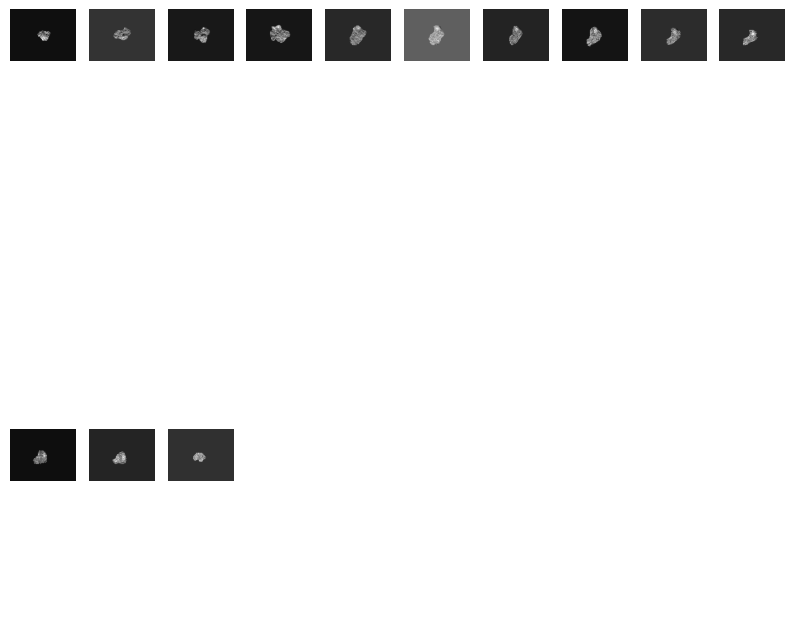

CroppedSegment shape: (13, 92, 118)


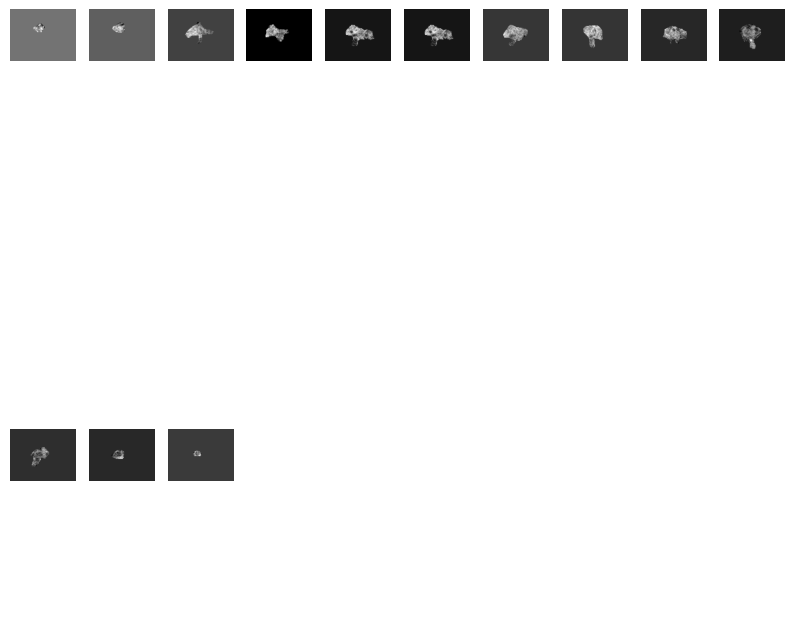

CroppedSegment shape: (13, 92, 118)


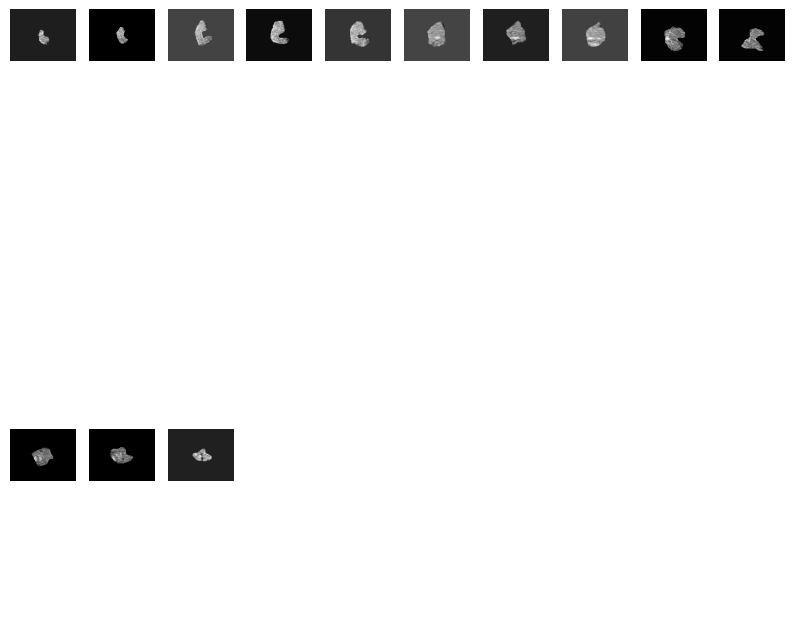

CroppedSegment shape: (13, 92, 118)


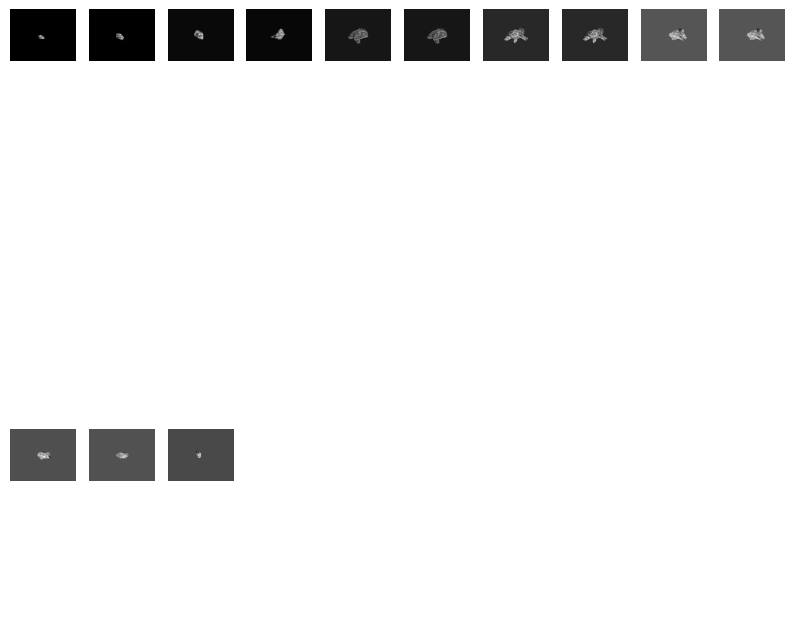

CroppedSegment shape: (13, 92, 118)


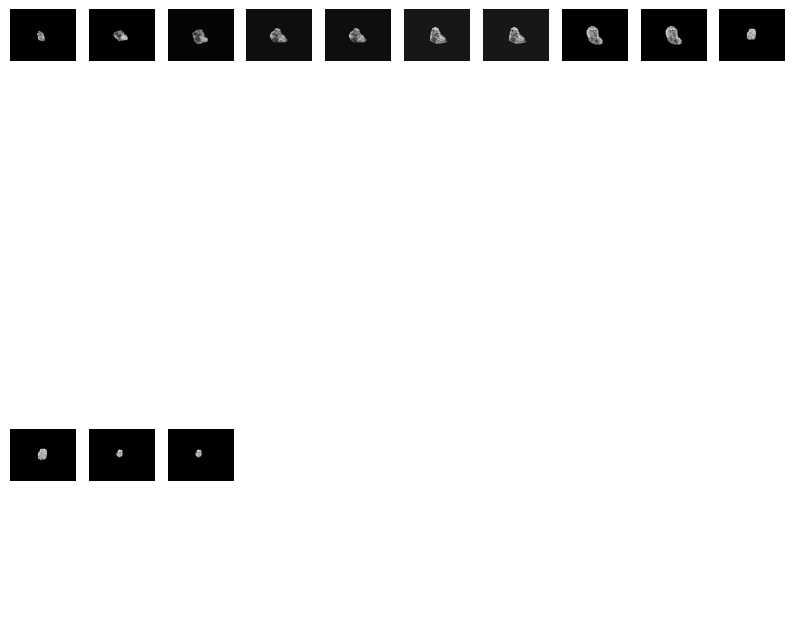

CroppedSegment shape: (13, 92, 118)


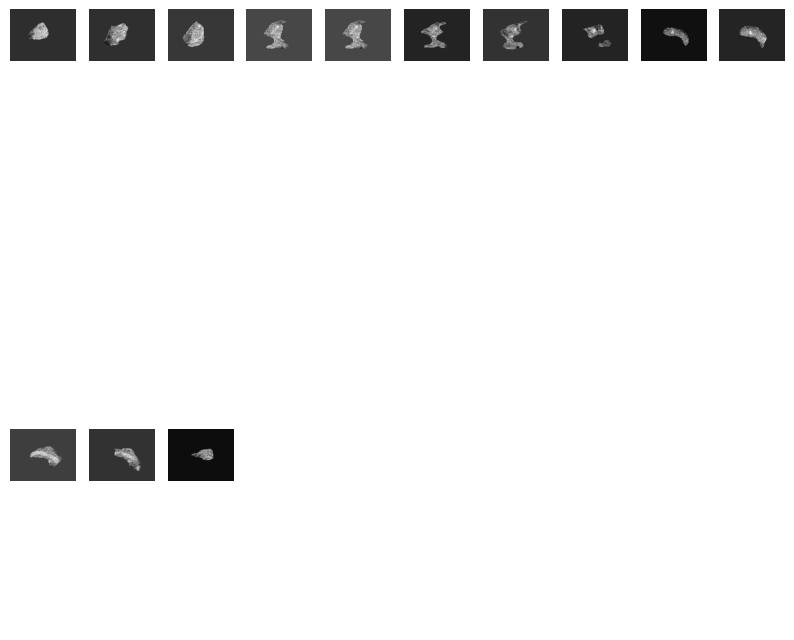

CroppedSegment shape: (13, 92, 118)


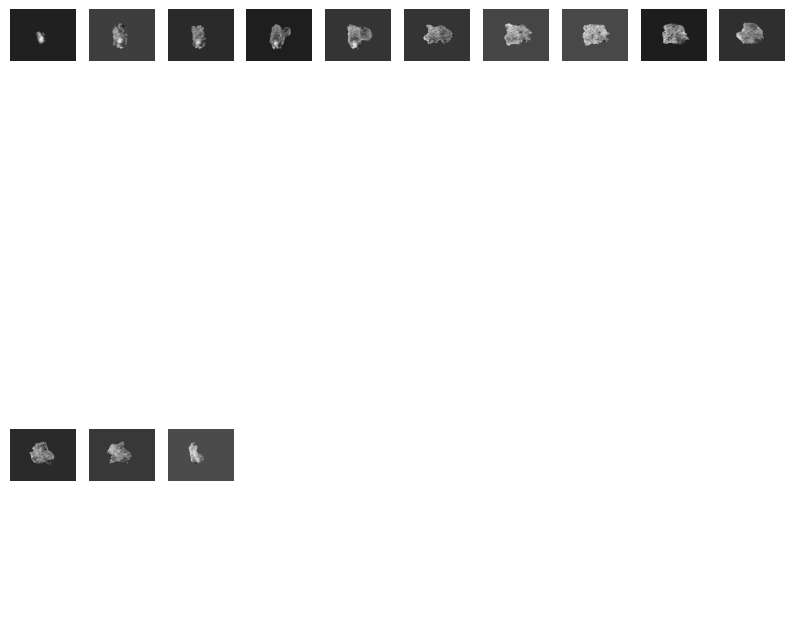

CroppedSegment shape: (13, 92, 118)


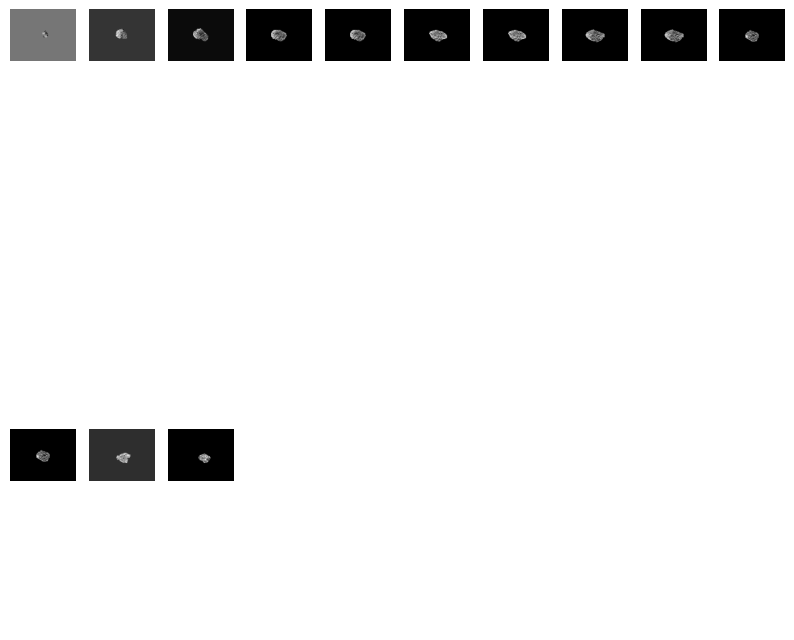

CroppedSegment shape: (13, 92, 118)


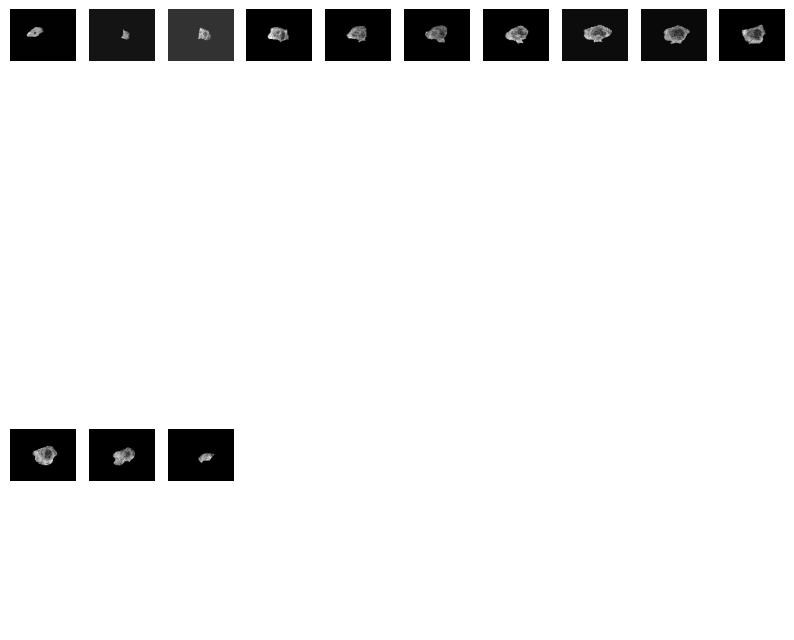

CroppedSegment shape: (13, 92, 118)


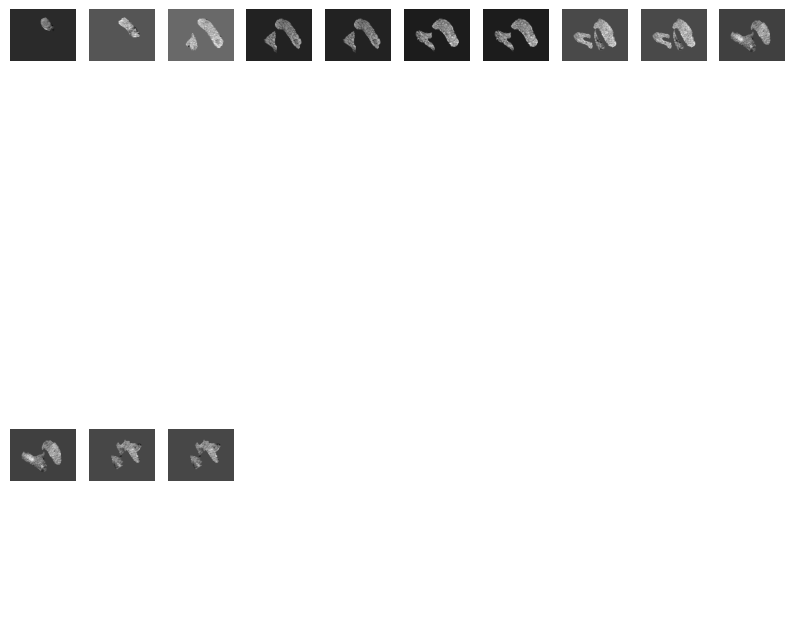

CroppedSegment shape: (13, 92, 118)


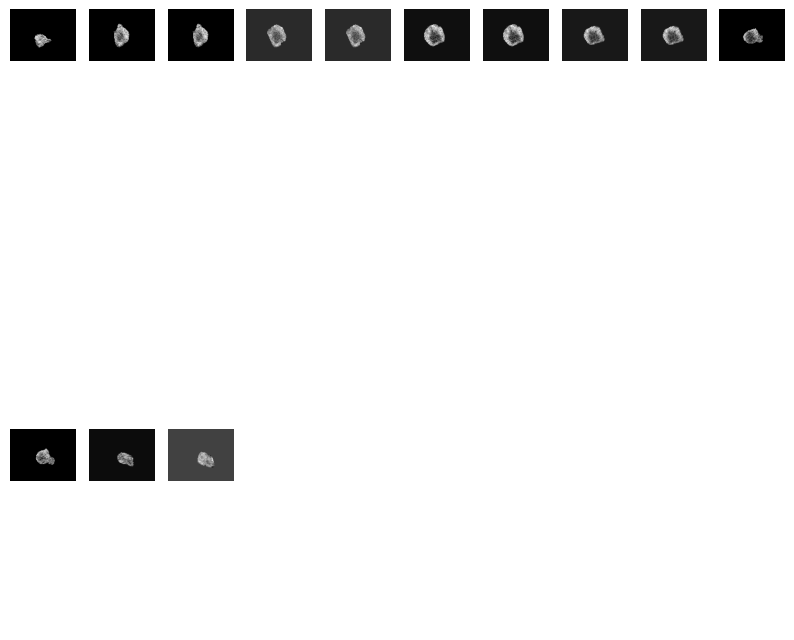

CroppedSegment shape: (13, 92, 118)


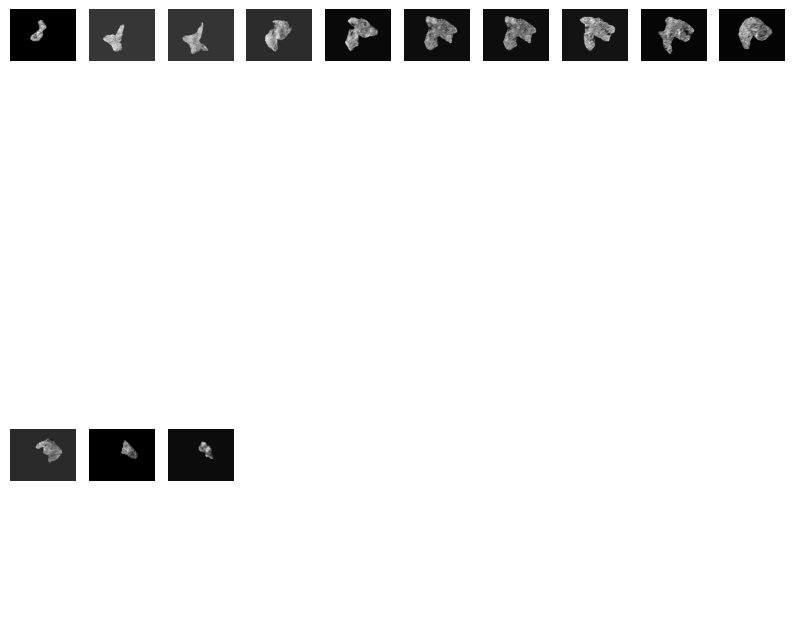

CroppedSegment shape: (13, 92, 118)


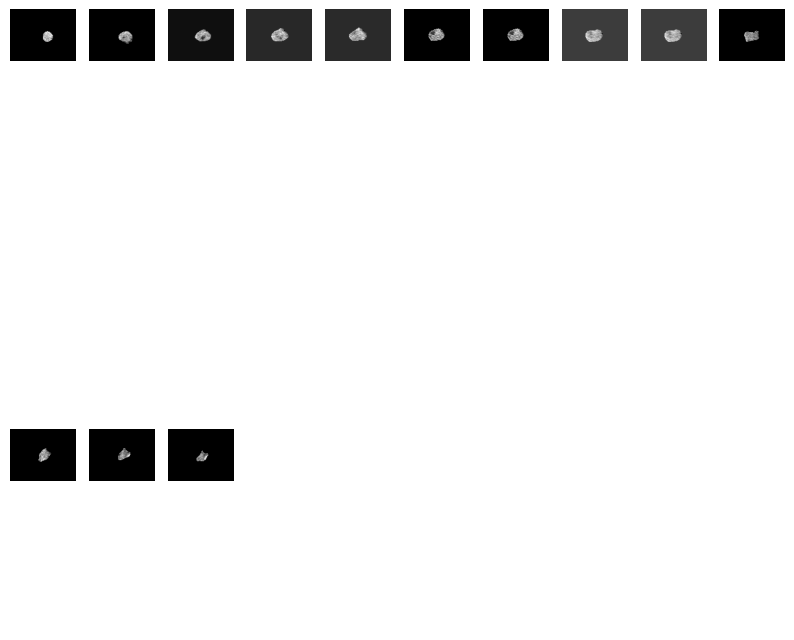

CroppedSegment shape: (13, 92, 118)


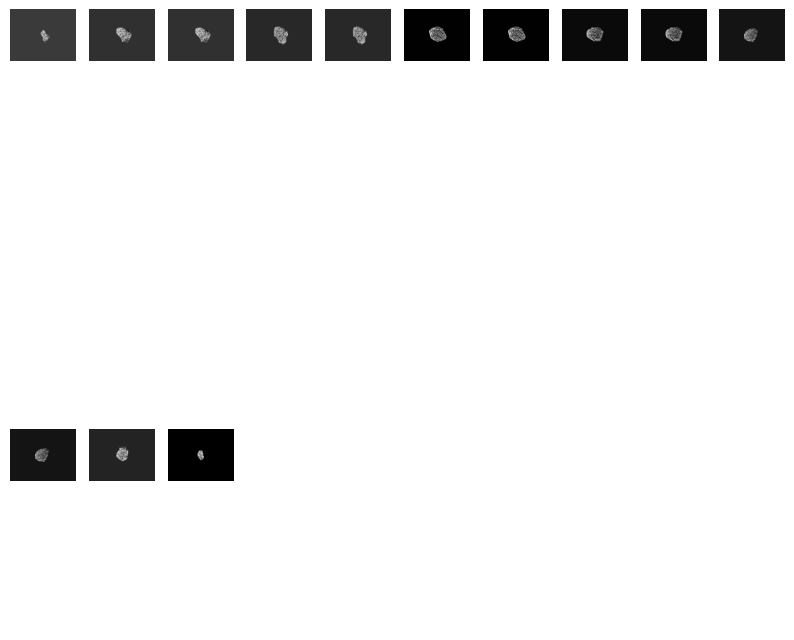

CroppedSegment shape: (13, 92, 118)


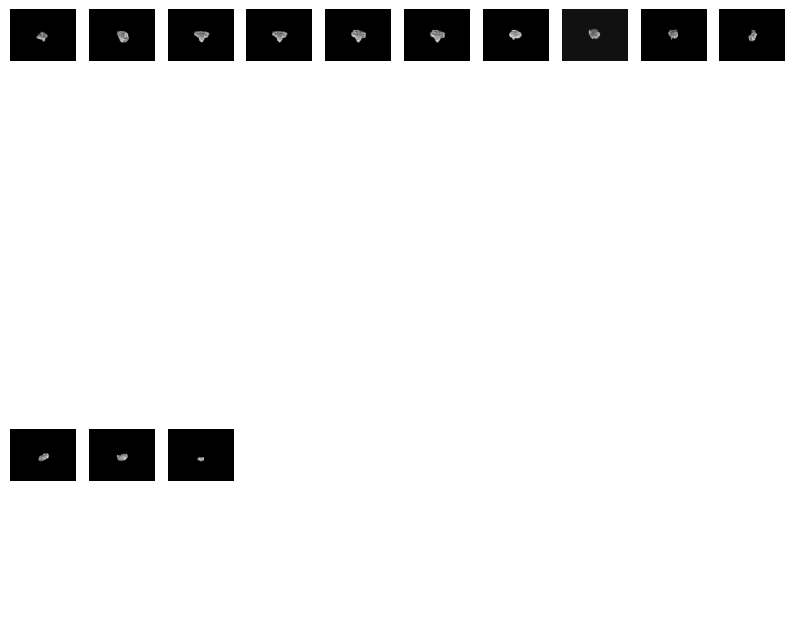

CroppedSegment shape: (13, 92, 118)


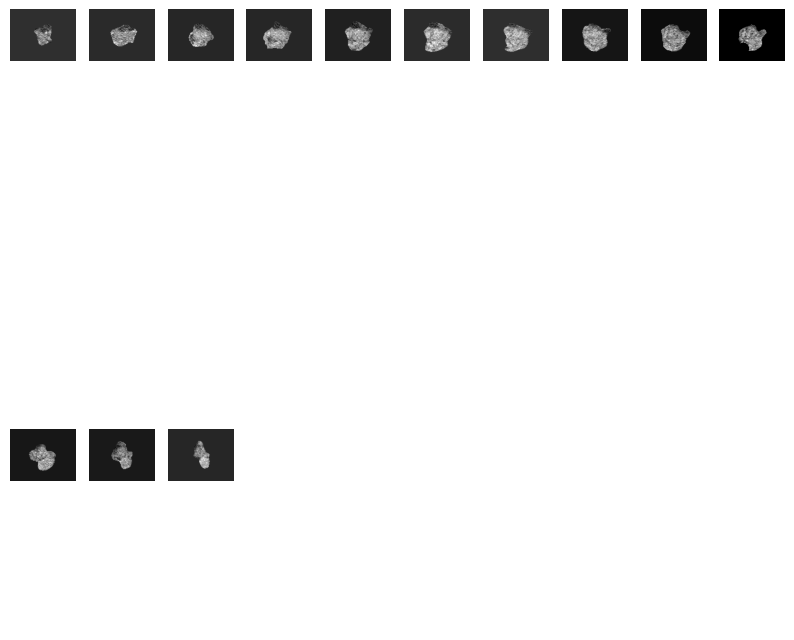

CroppedSegment shape: (13, 92, 118)


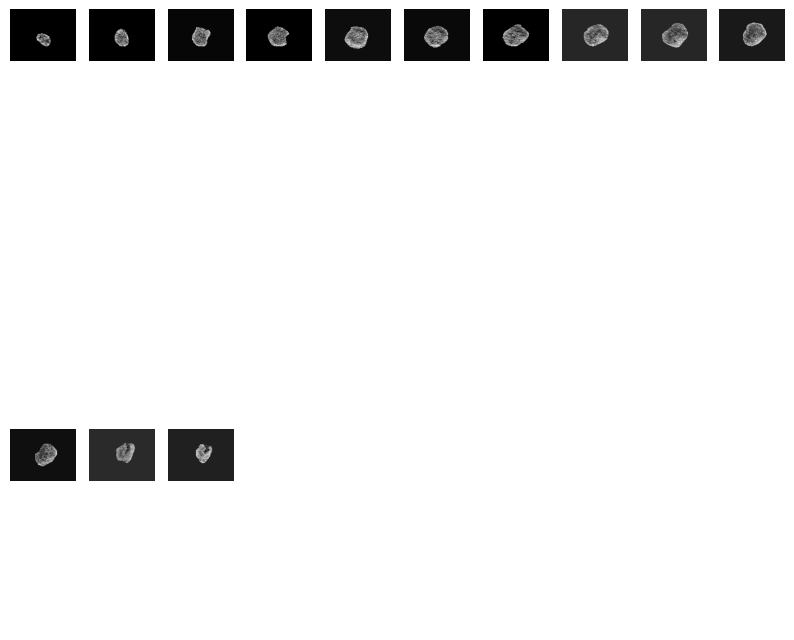

CroppedSegment shape: (13, 92, 118)


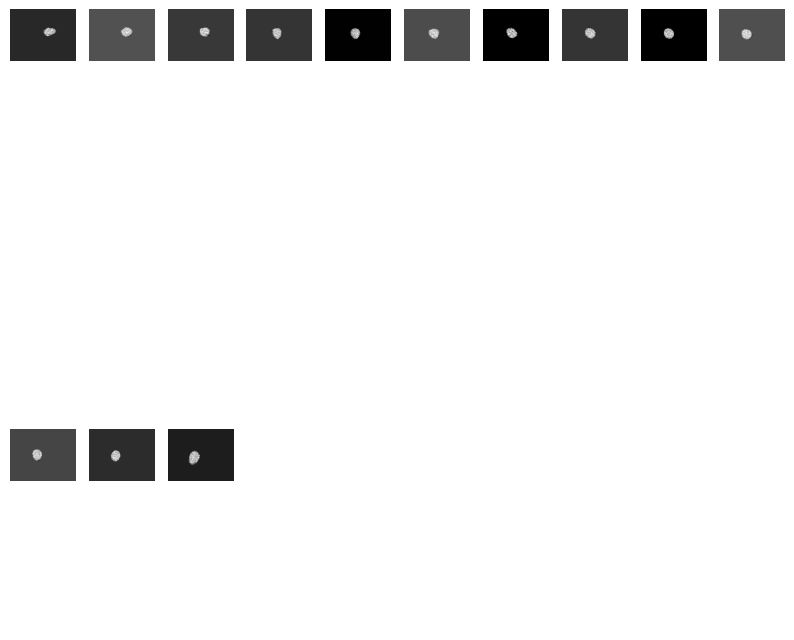

CroppedSegment shape: (13, 92, 118)


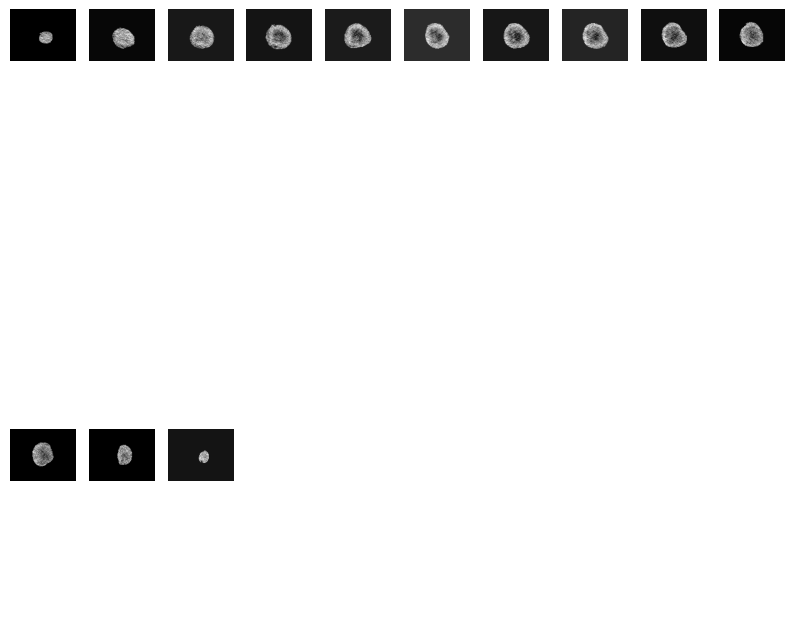

CroppedSegment shape: (13, 92, 118)


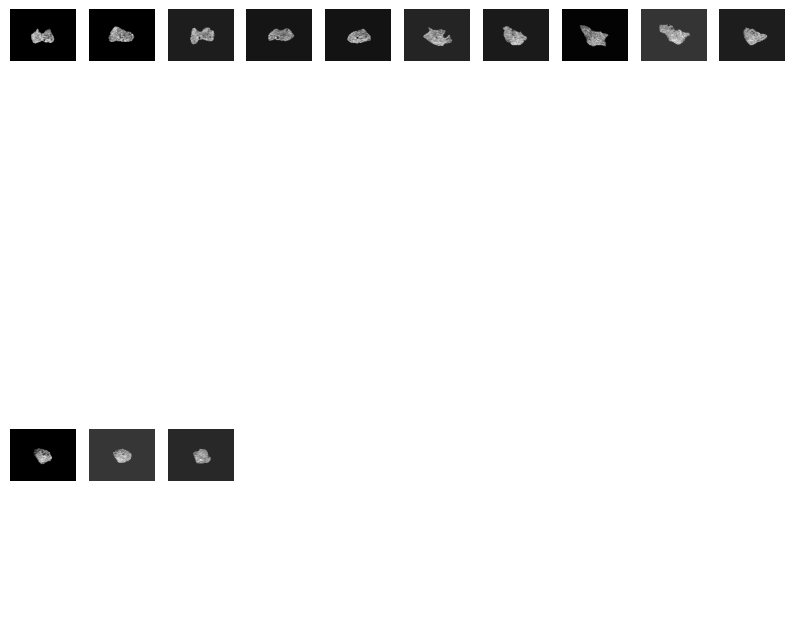

CroppedSegment shape: (13, 92, 118)


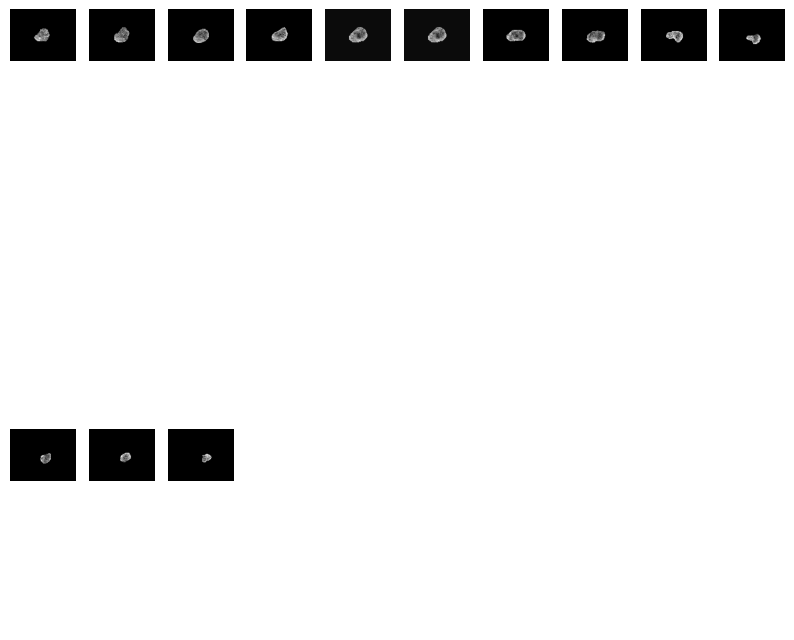

CroppedSegment shape: (13, 92, 118)


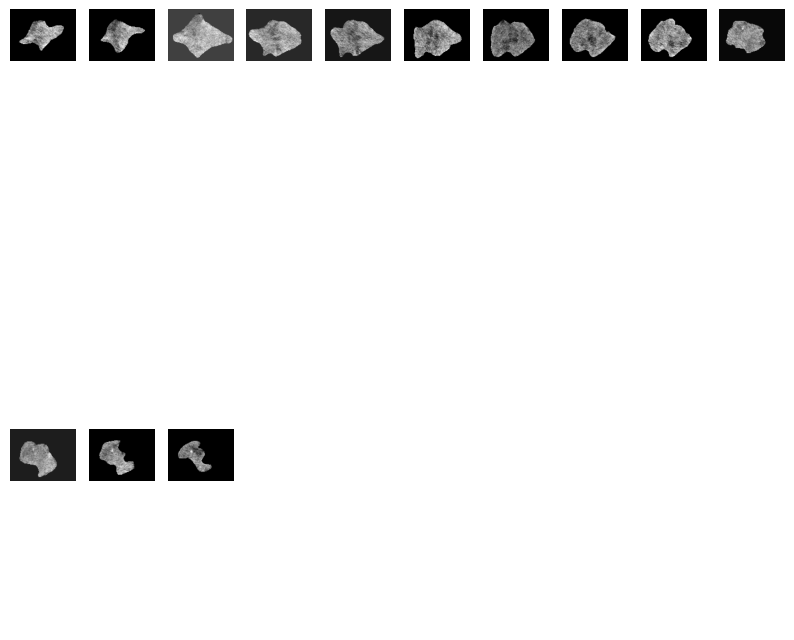

CroppedSegment shape: (13, 92, 118)


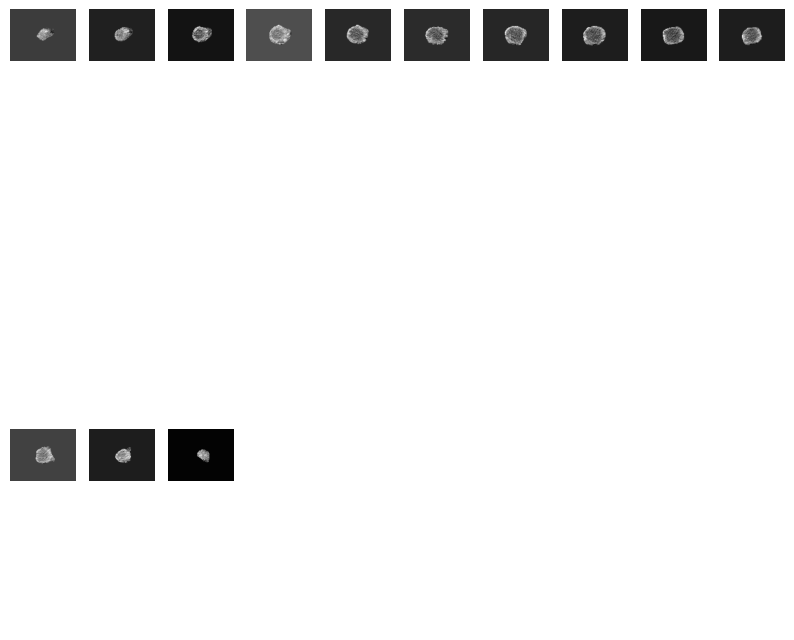

CroppedSegment shape: (13, 92, 118)


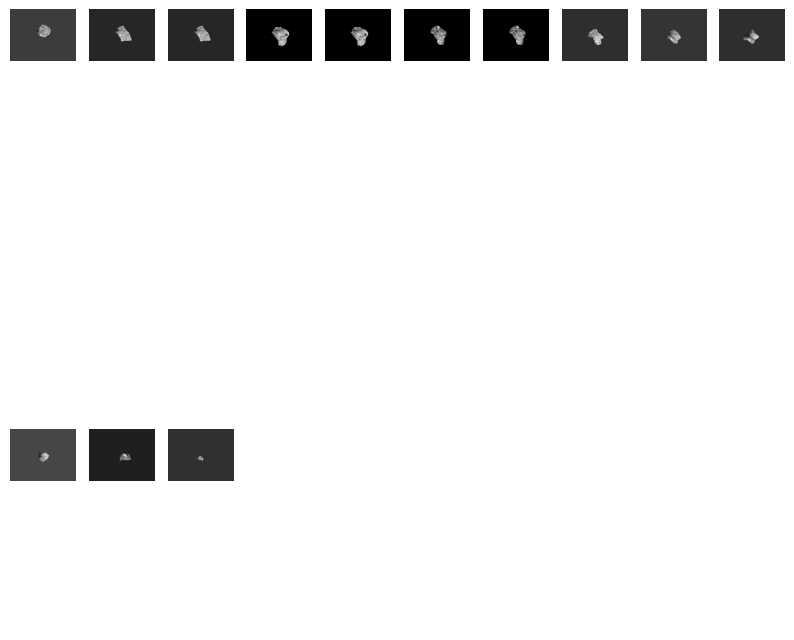

CroppedSegment shape: (13, 92, 118)


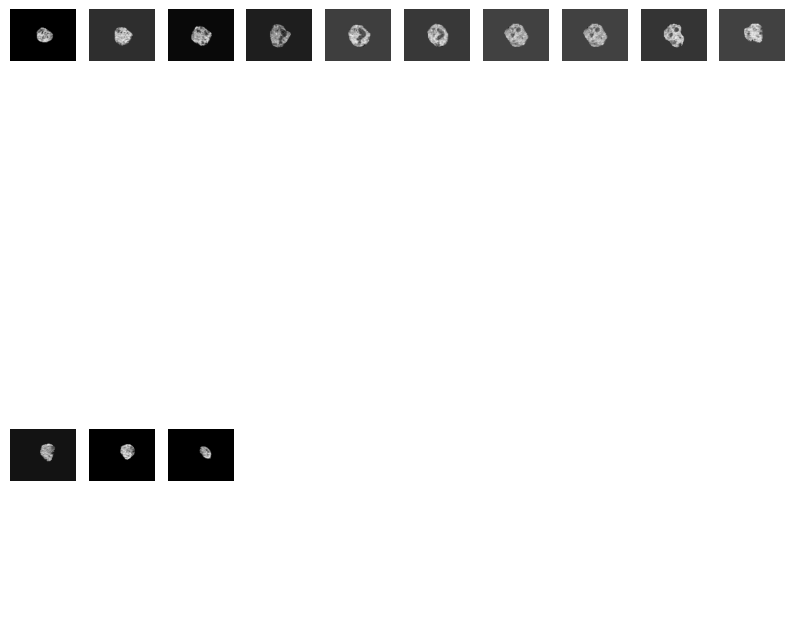

CroppedSegment shape: (13, 92, 118)


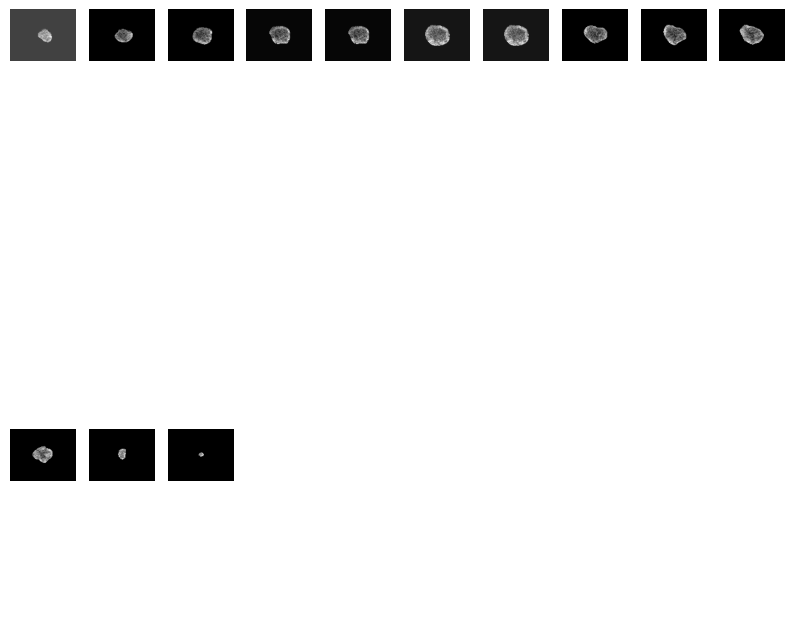

CroppedSegment shape: (13, 92, 118)


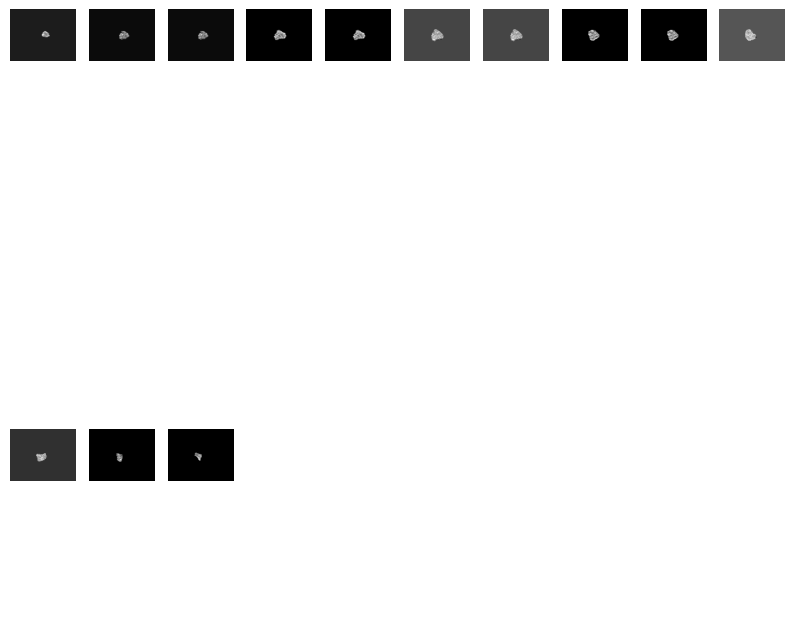

CroppedSegment shape: (13, 92, 118)


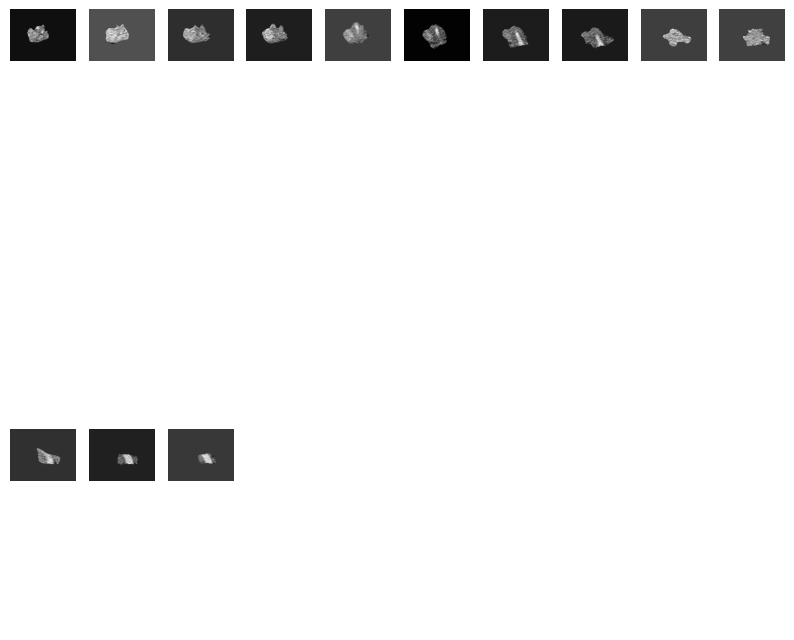

CroppedSegment shape: (13, 92, 118)


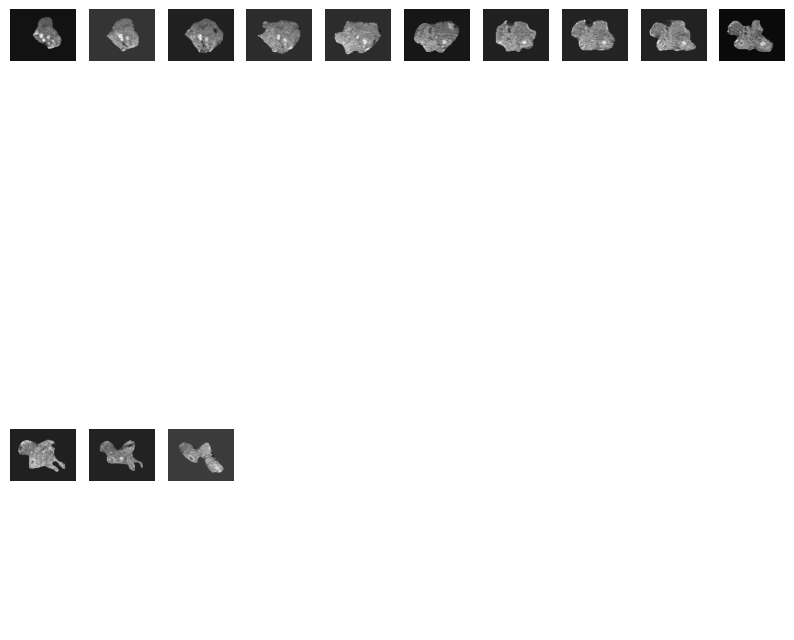

CroppedSegment shape: (13, 92, 118)


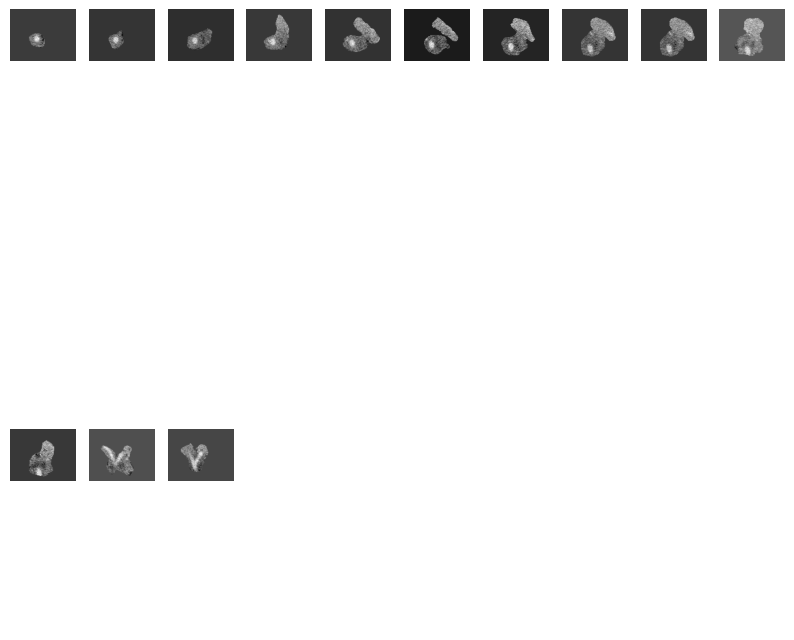

CroppedSegment shape: (13, 92, 118)


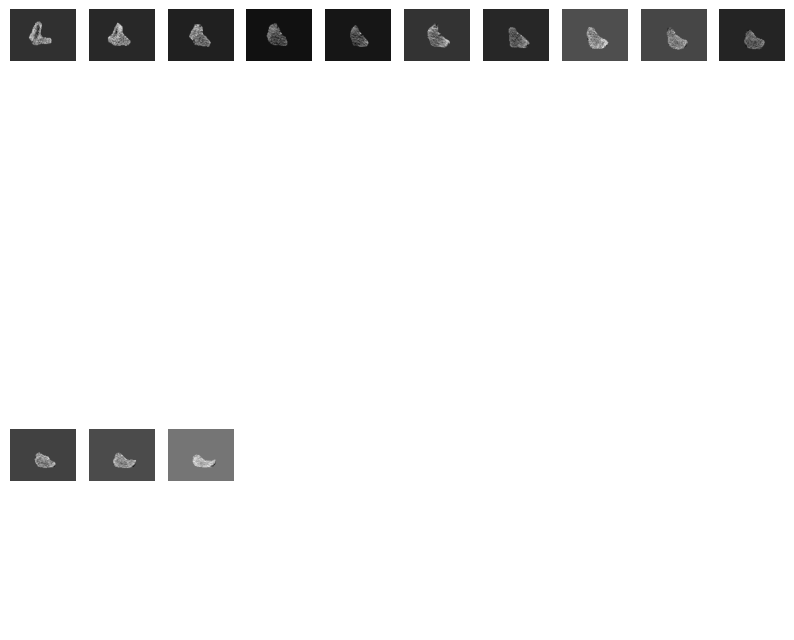

CroppedSegment shape: (13, 92, 118)


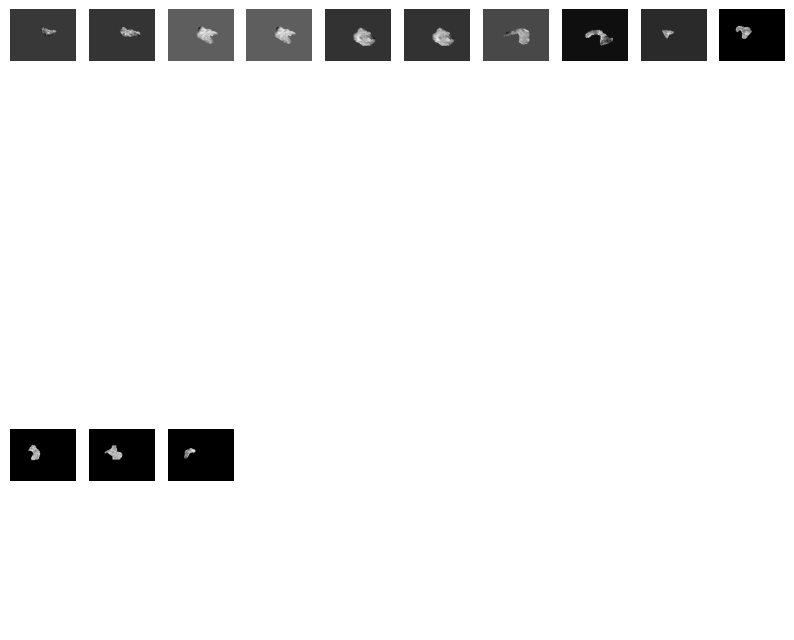

CroppedSegment shape: (13, 92, 118)


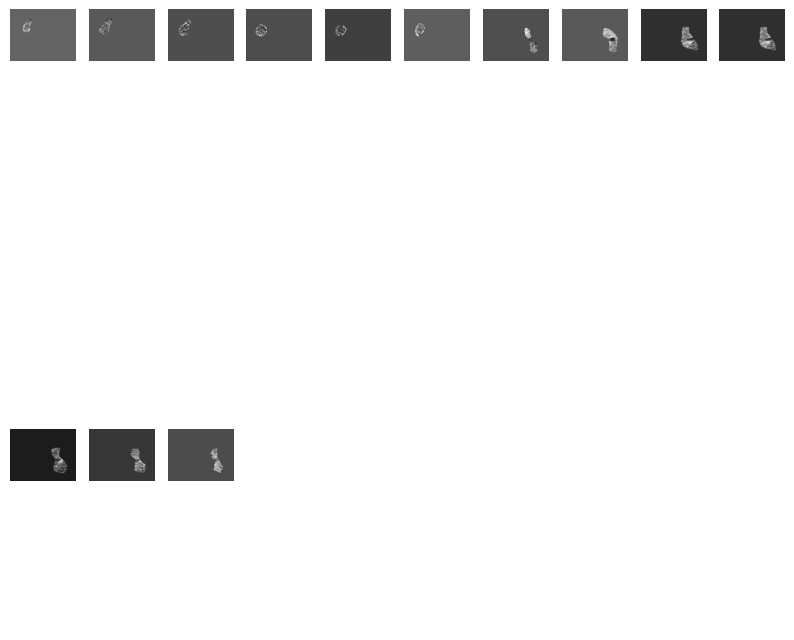

CroppedSegment shape: (13, 92, 118)


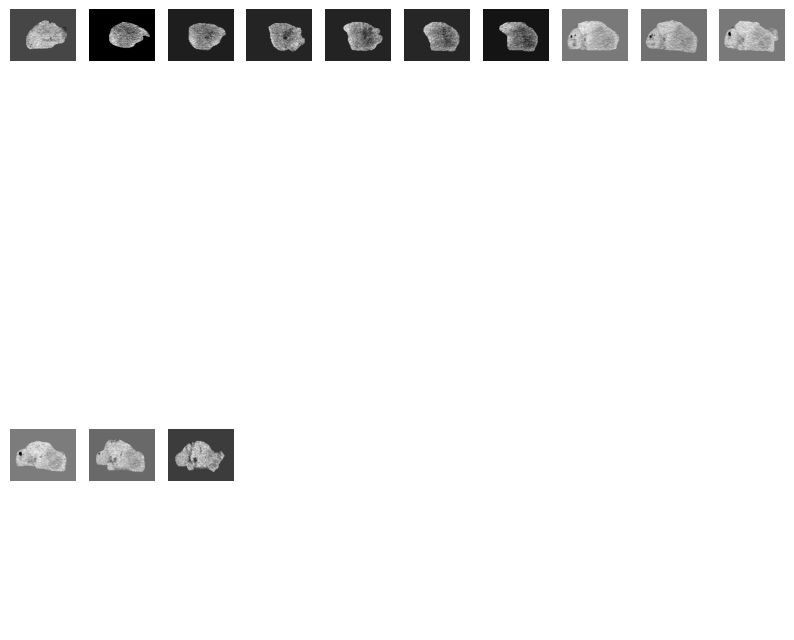

CroppedSegment shape: (13, 92, 118)


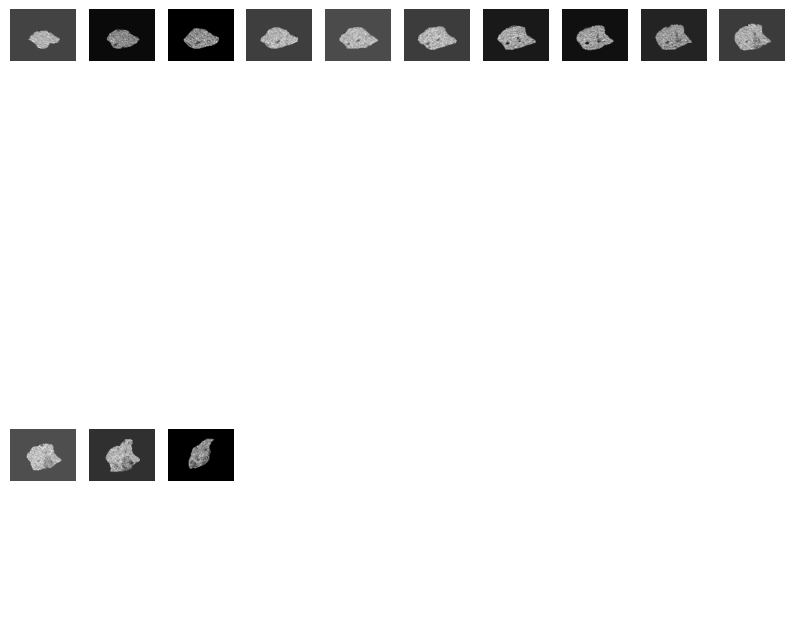

CroppedSegment shape: (13, 92, 118)


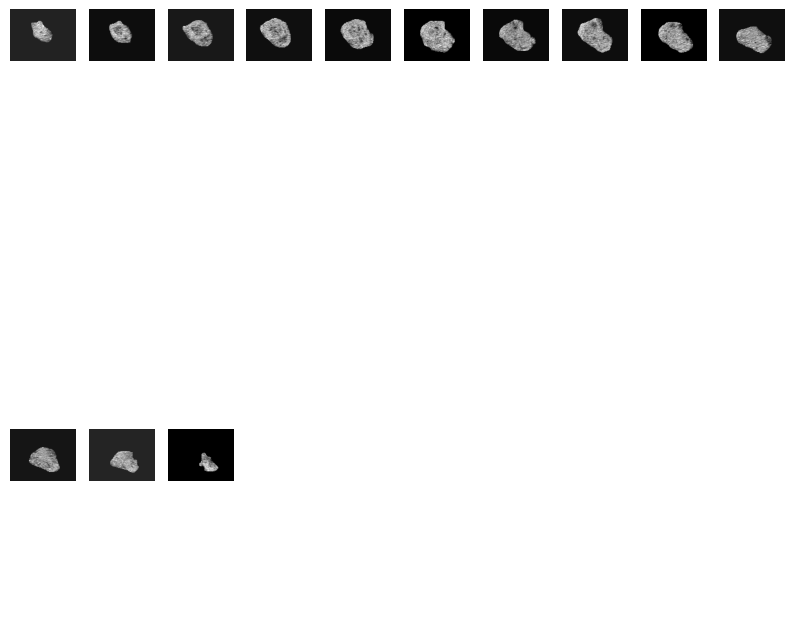

CroppedSegment shape: (13, 92, 118)


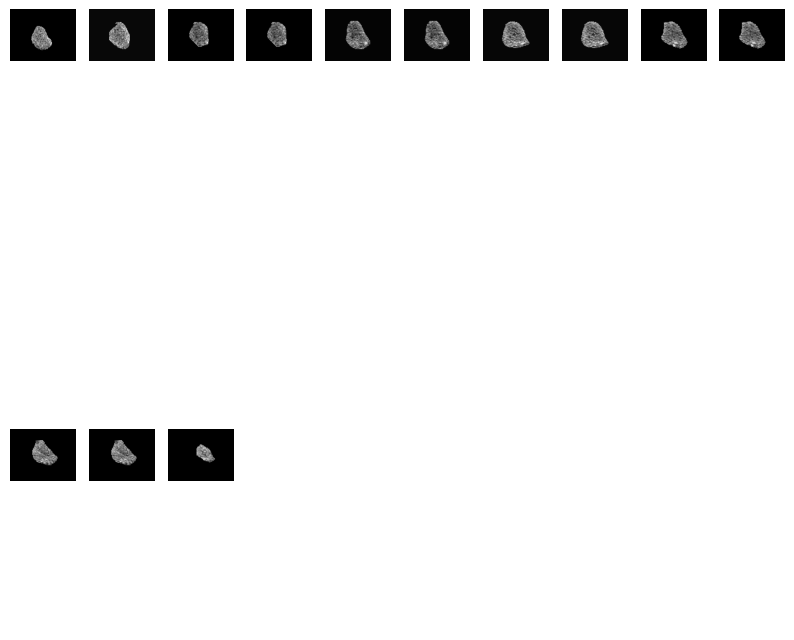

CroppedSegment shape: (13, 92, 118)


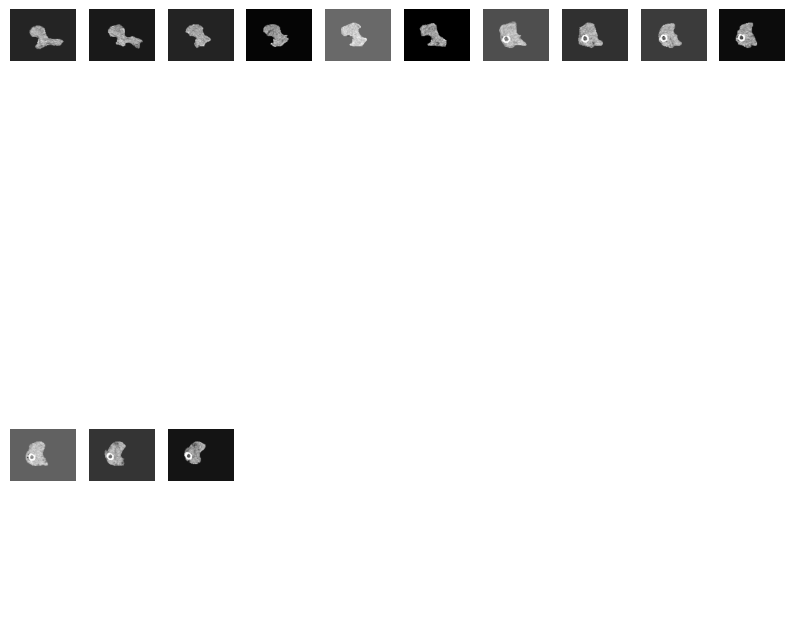

CroppedSegment shape: (13, 92, 118)


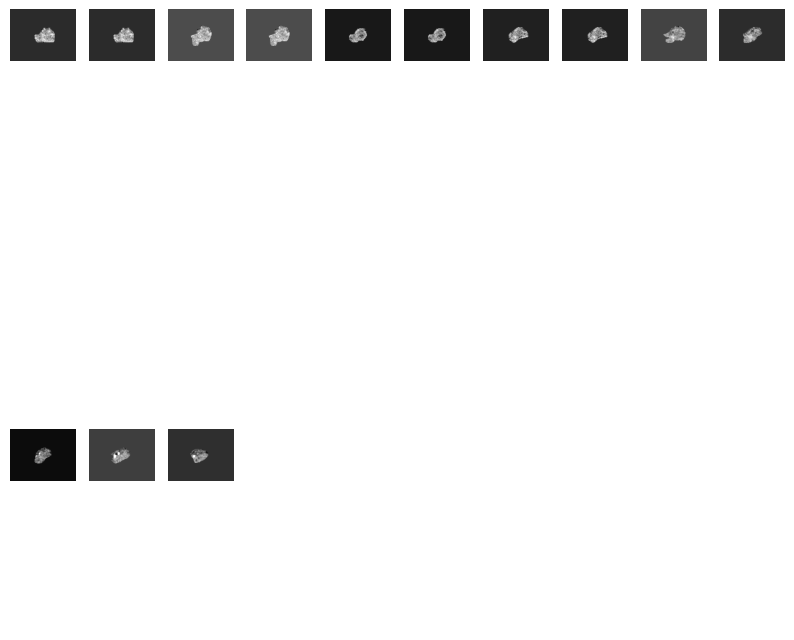

CroppedSegment shape: (13, 92, 118)


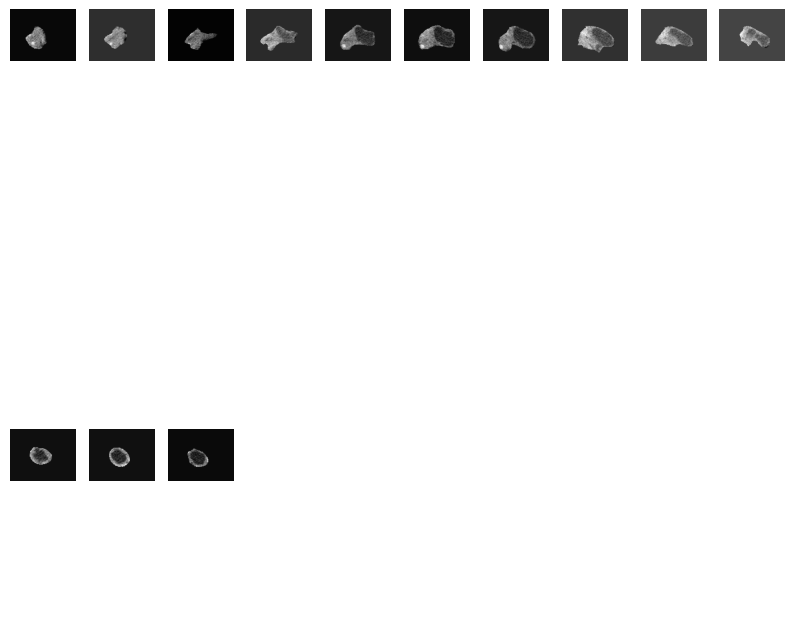

CroppedSegment shape: (13, 92, 118)


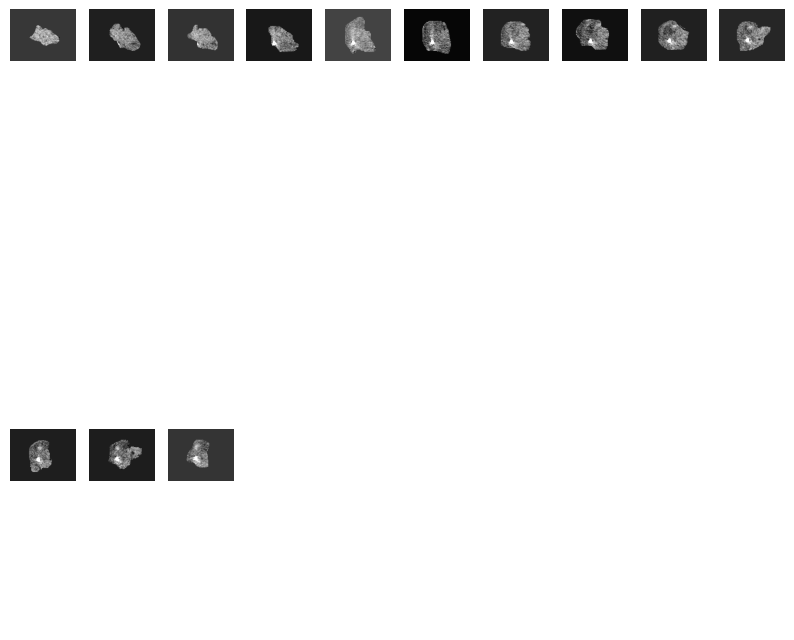

CroppedSegment shape: (13, 92, 118)


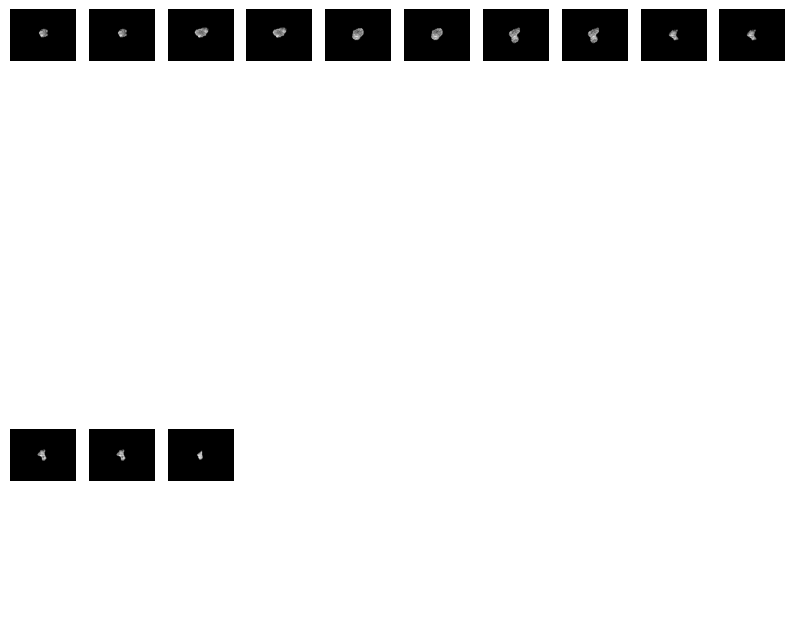

CroppedSegment shape: (13, 92, 118)


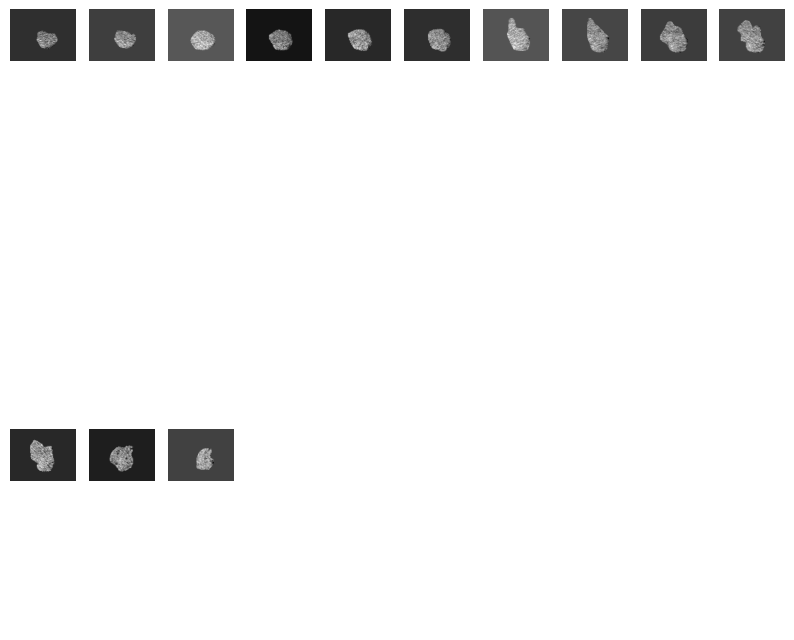

CroppedSegment shape: (13, 92, 118)


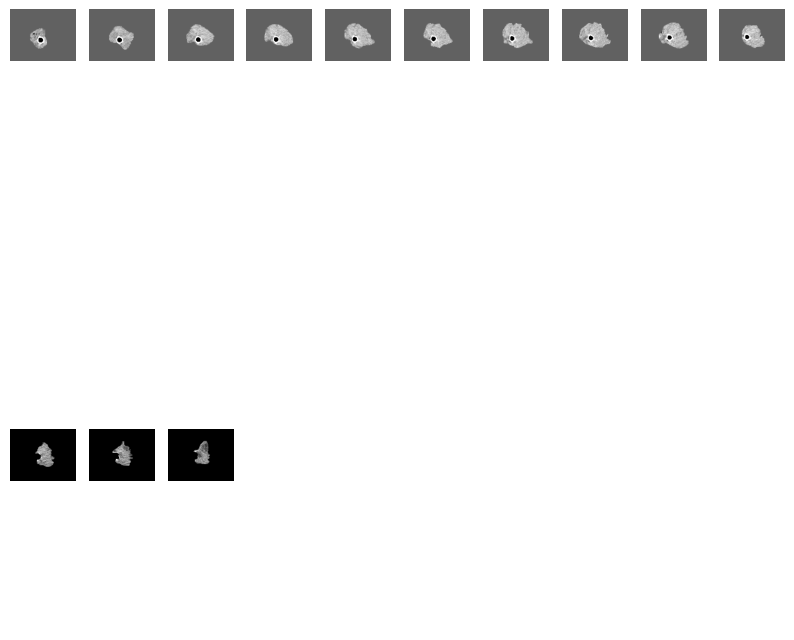

CroppedSegment shape: (13, 92, 118)


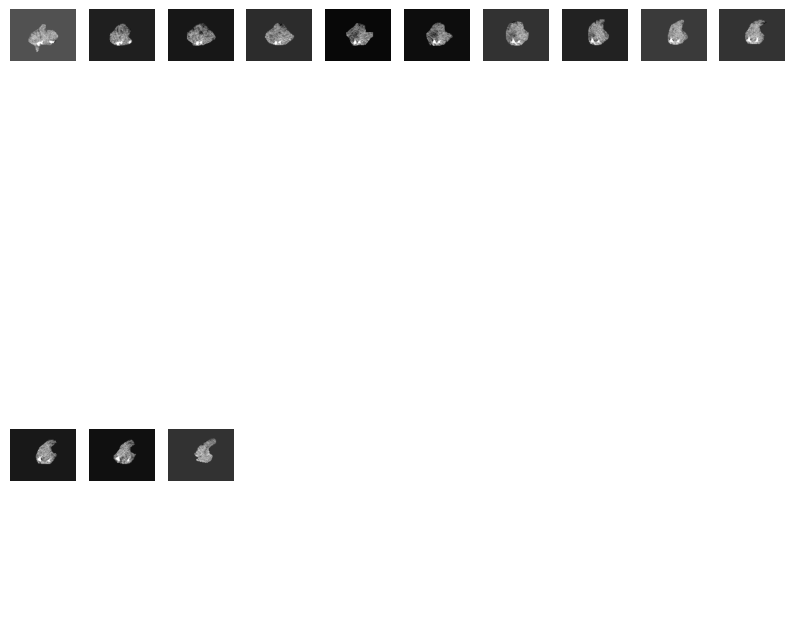

CroppedSegment shape: (13, 92, 118)


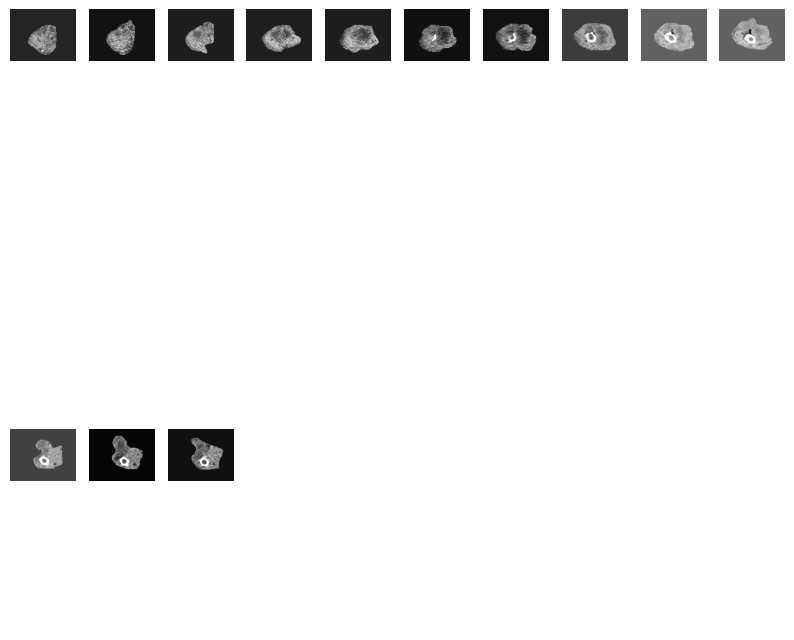

CroppedSegment shape: (13, 92, 118)


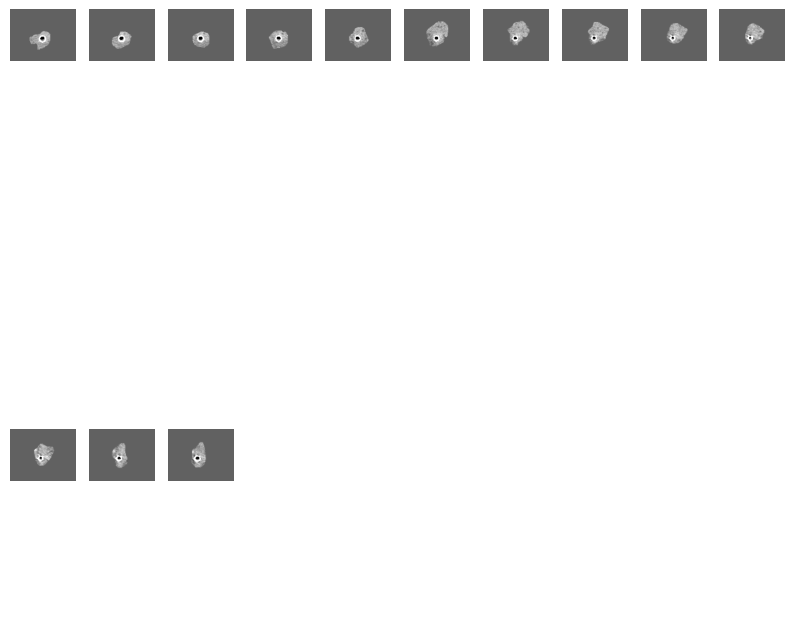

CroppedSegment shape: (13, 92, 118)


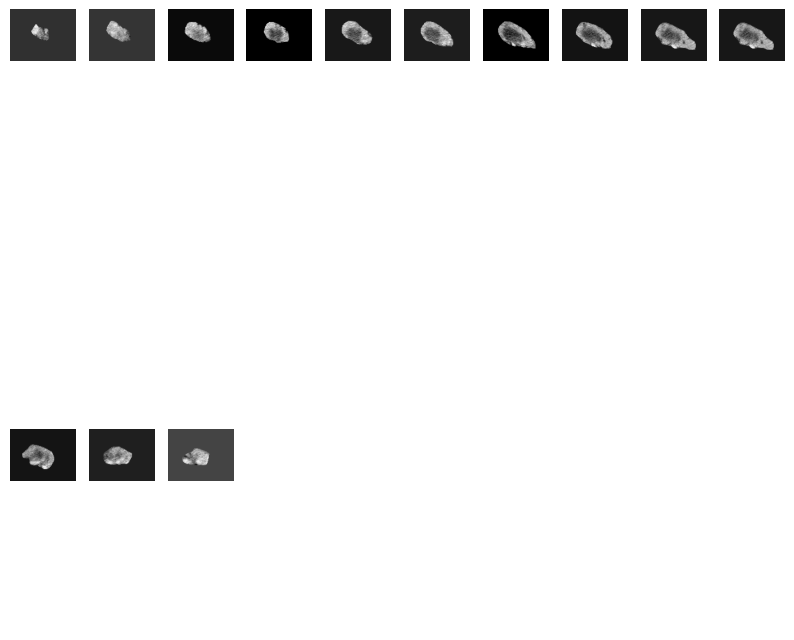

CroppedSegment shape: (13, 92, 118)


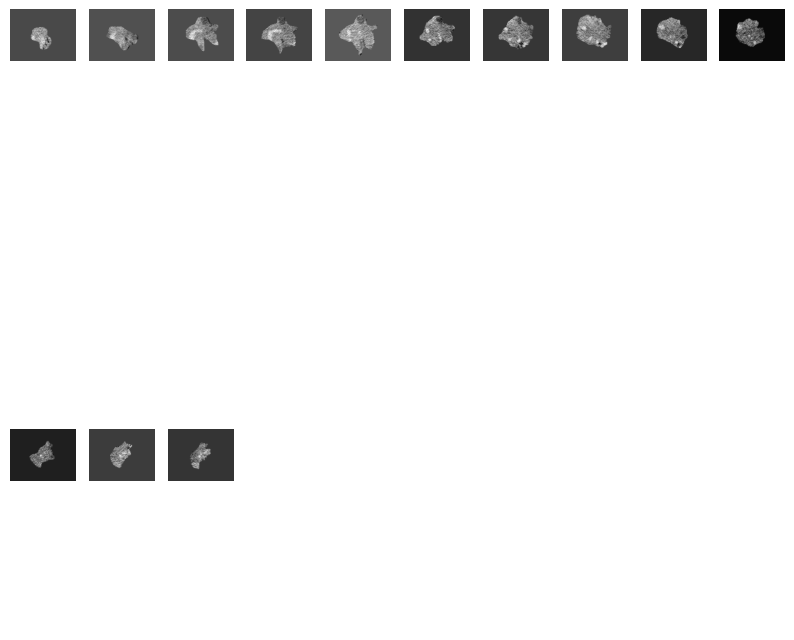

CroppedSegment shape: (13, 92, 118)


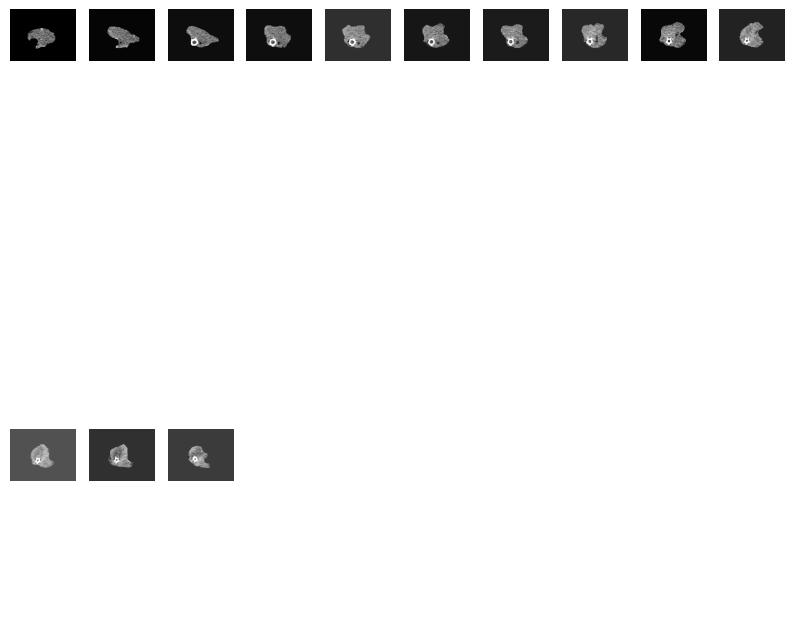

CroppedSegment shape: (13, 92, 118)


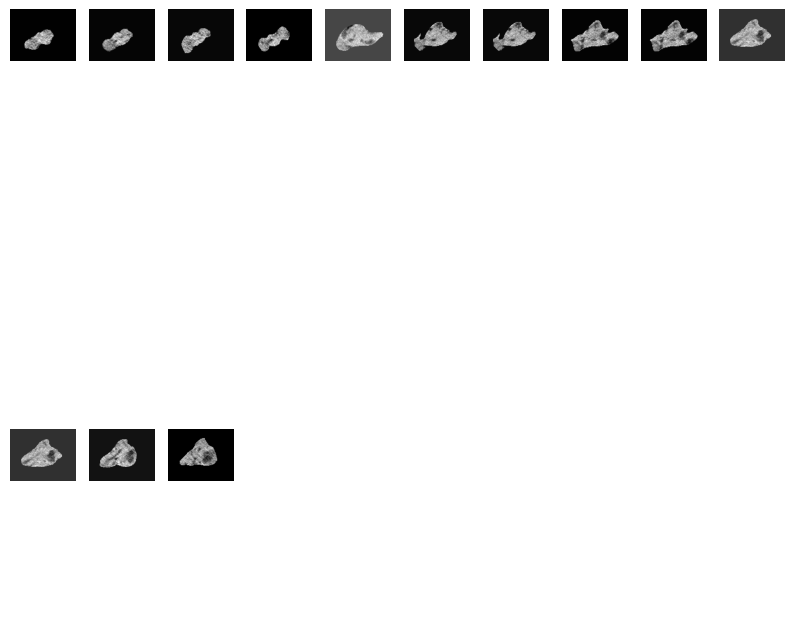

CroppedSegment shape: (13, 92, 118)


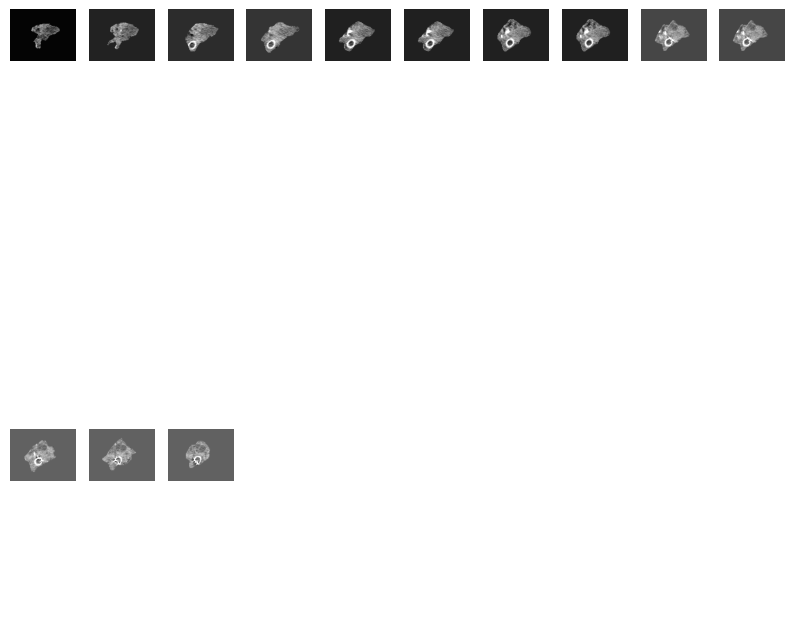

CroppedSegment shape: (13, 92, 118)


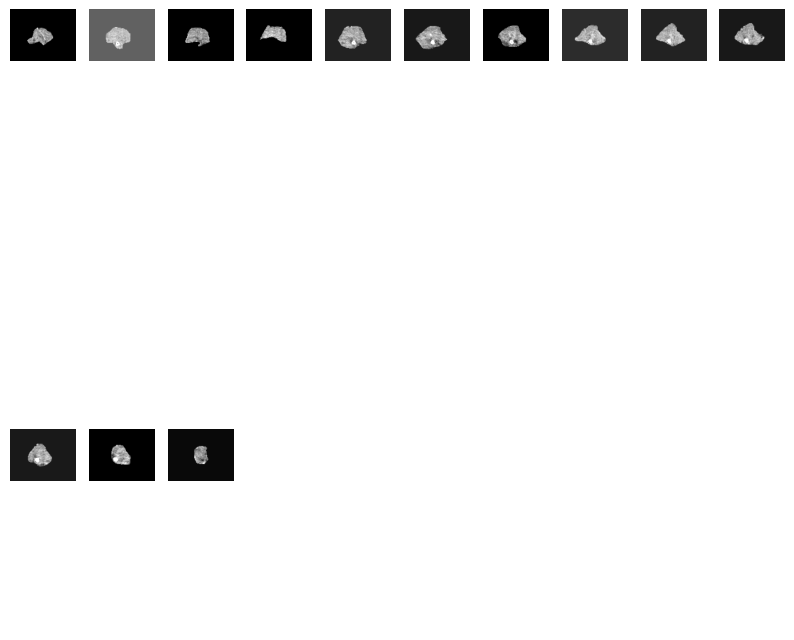

CroppedSegment shape: (13, 92, 118)


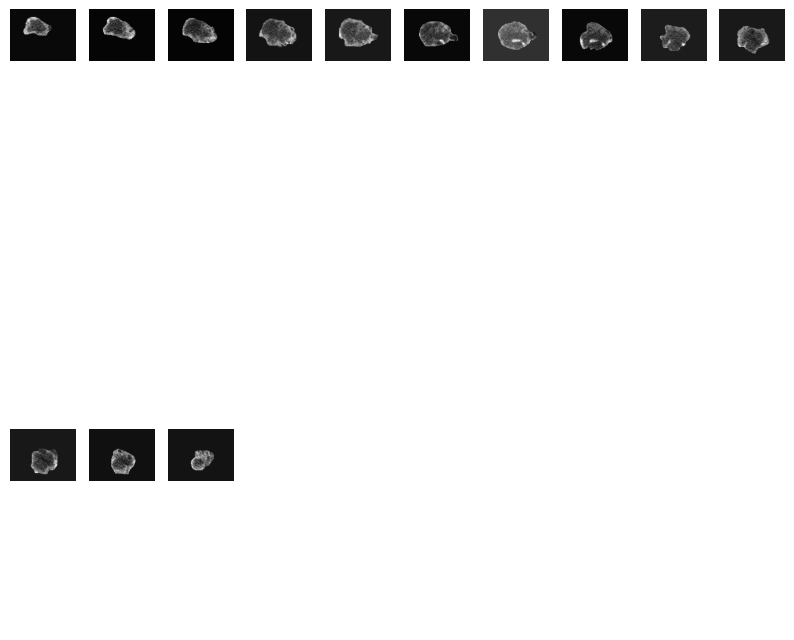

CroppedSegment shape: (13, 92, 118)


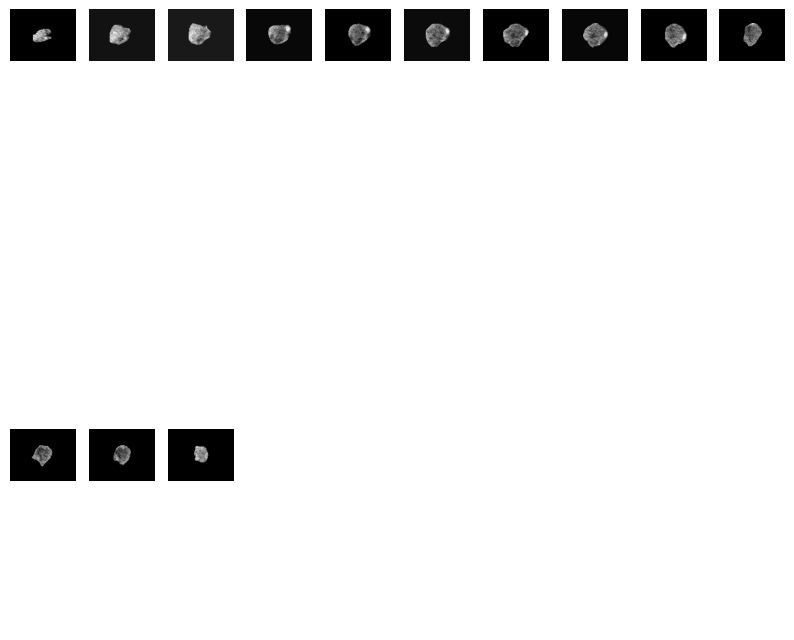

CroppedSegment shape: (13, 92, 118)


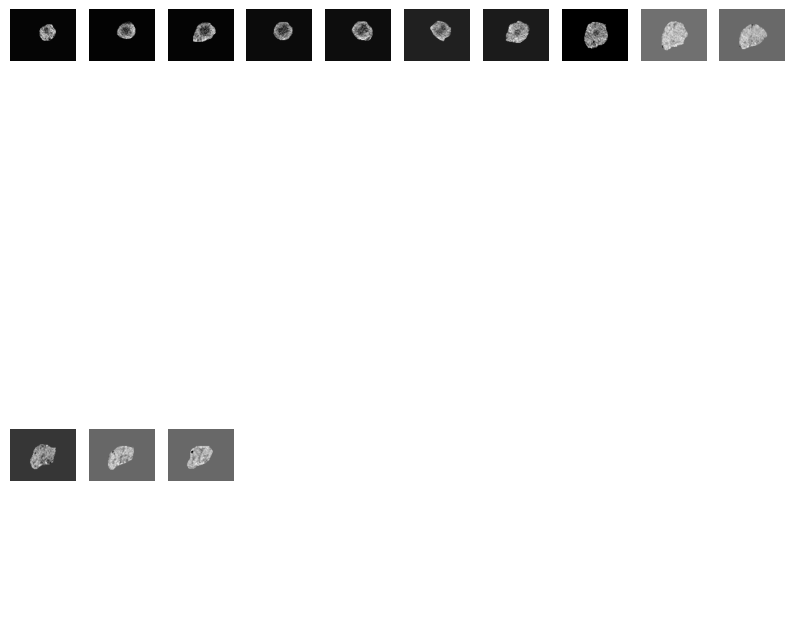

CroppedSegment shape: (13, 92, 118)


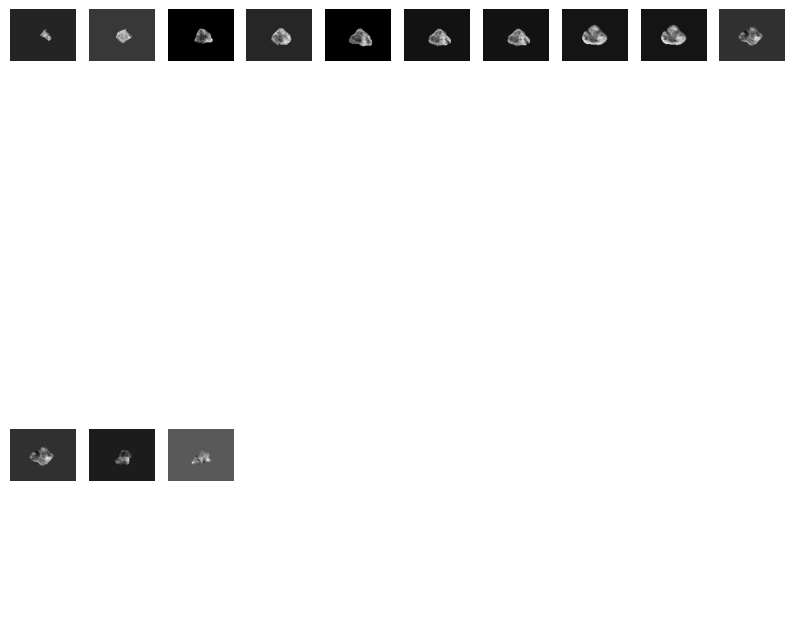

CroppedSegment shape: (13, 92, 118)


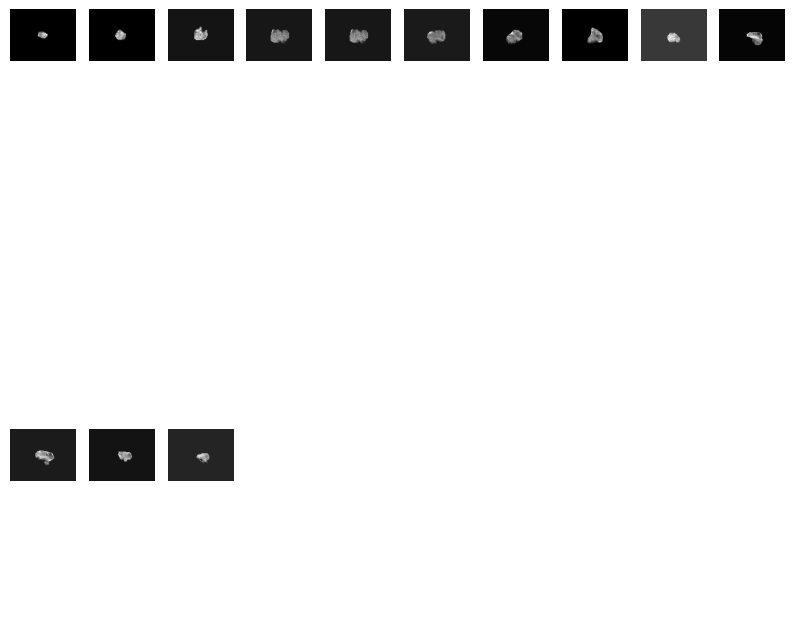

CroppedSegment shape: (13, 92, 118)


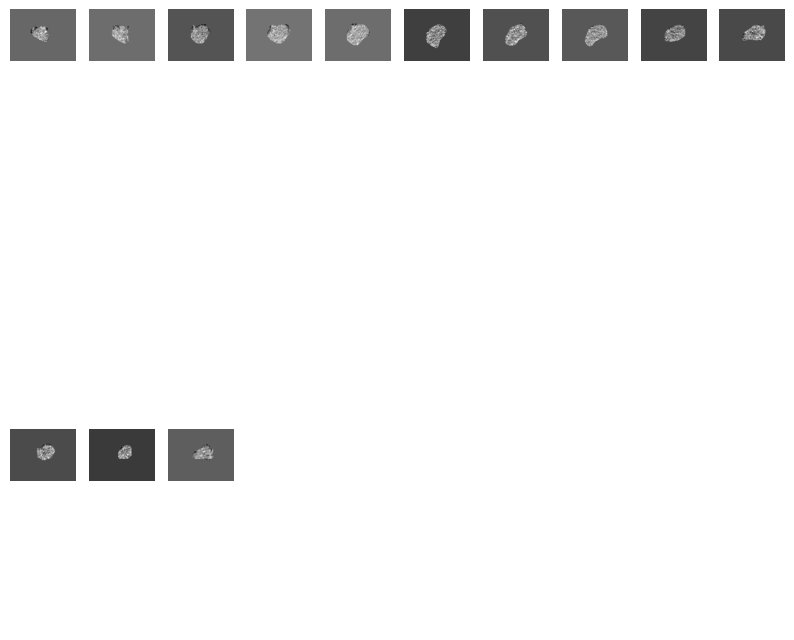

CroppedSegment shape: (13, 92, 118)


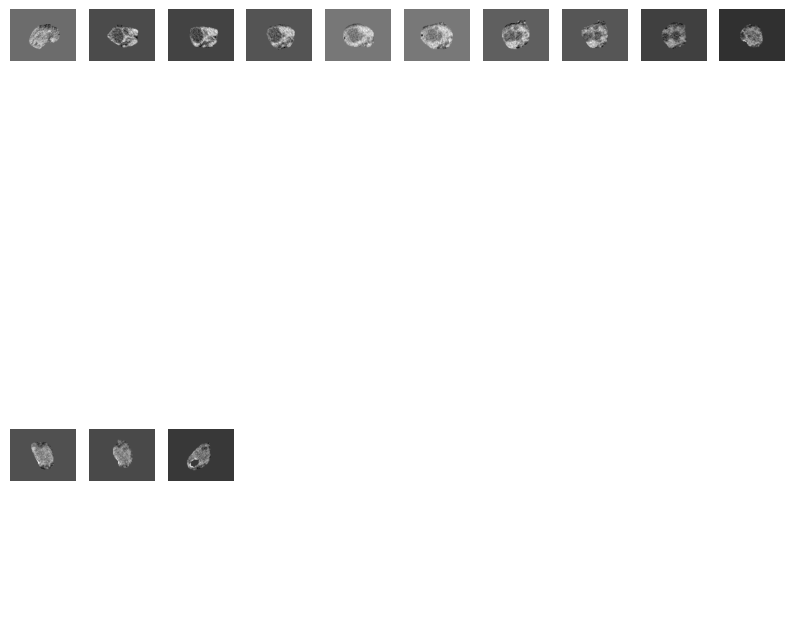

CroppedSegment shape: (13, 92, 118)


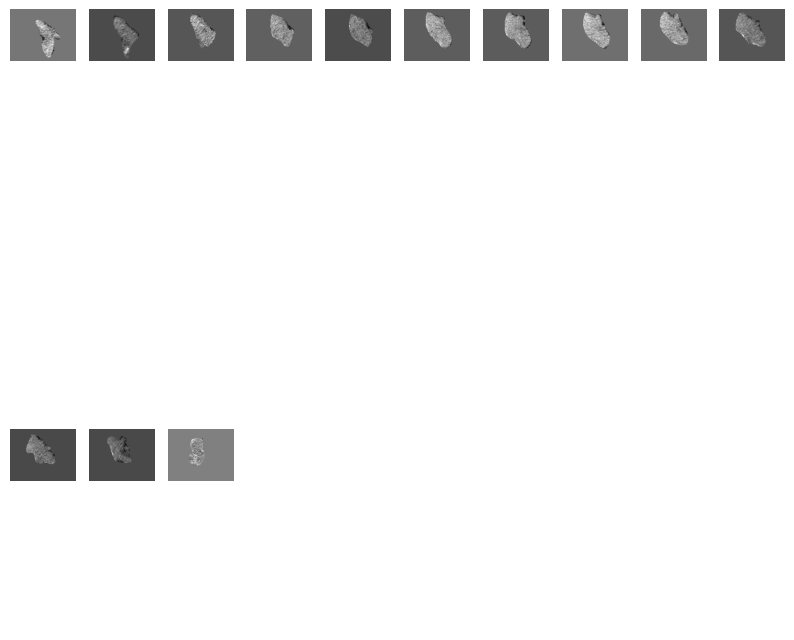

CroppedSegment shape: (13, 92, 118)


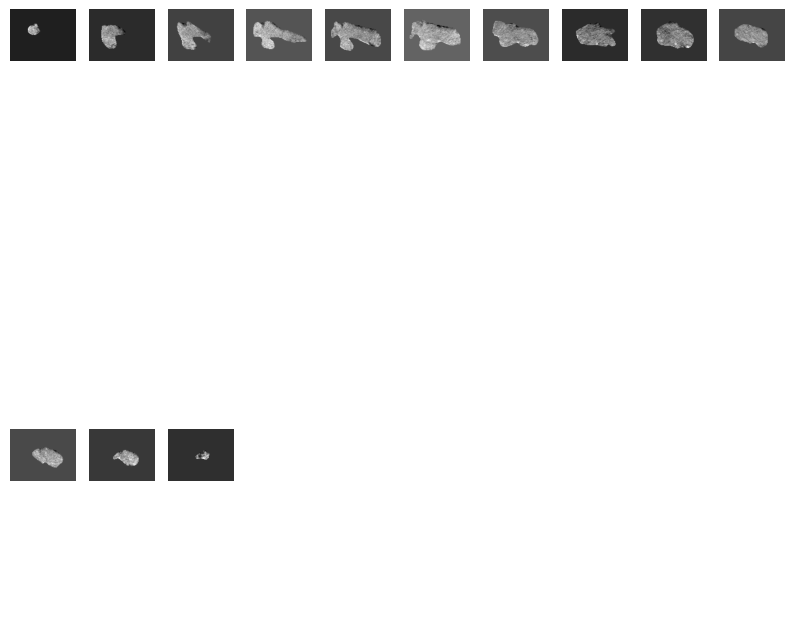

CroppedSegment shape: (13, 92, 118)


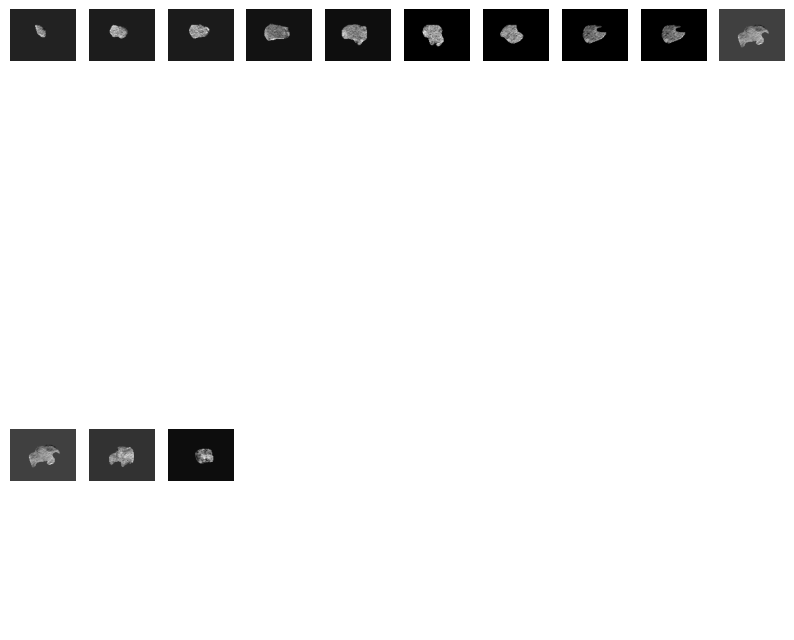

CroppedSegment shape: (13, 92, 118)


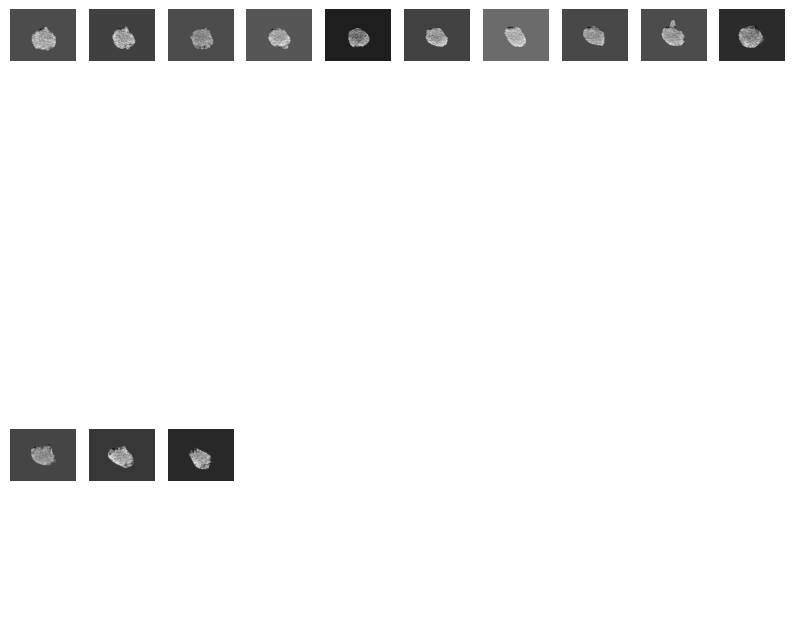

CroppedSegment shape: (13, 92, 118)


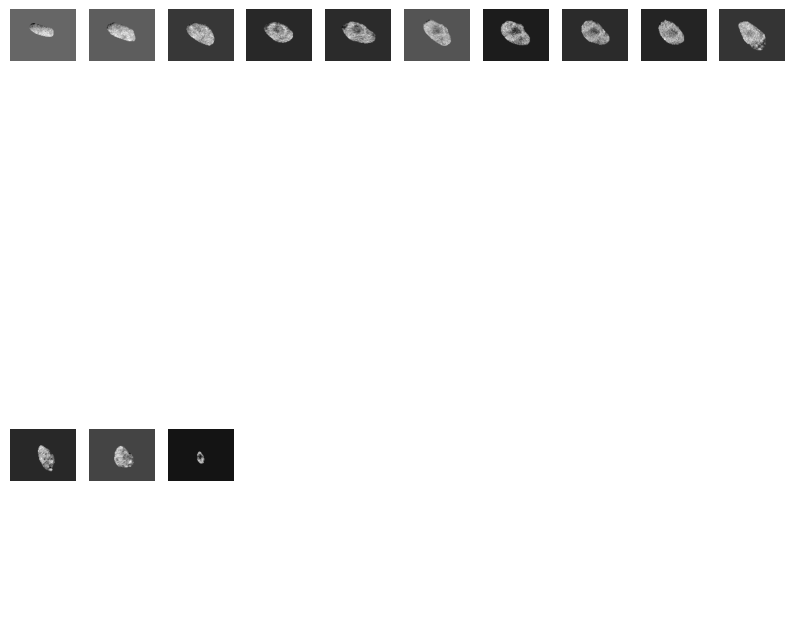

CroppedSegment shape: (13, 92, 118)


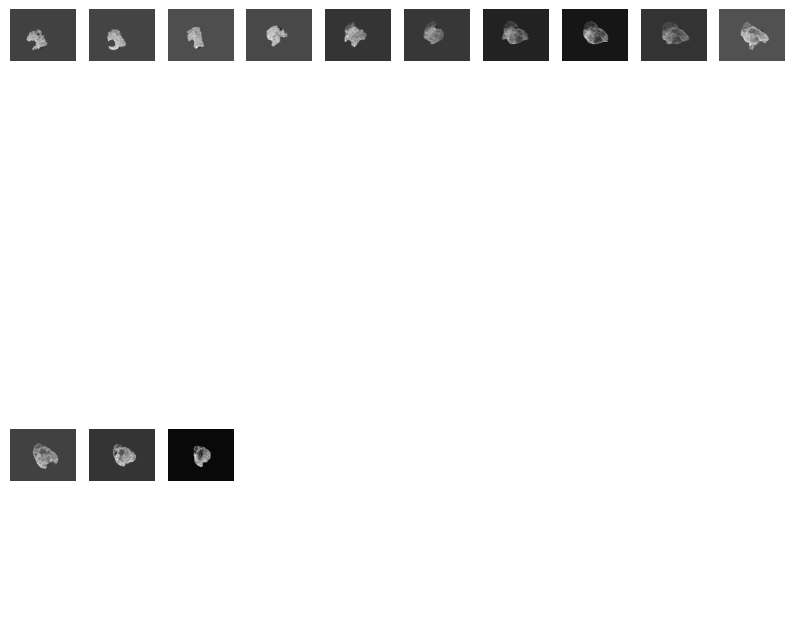

CroppedSegment shape: (13, 92, 118)


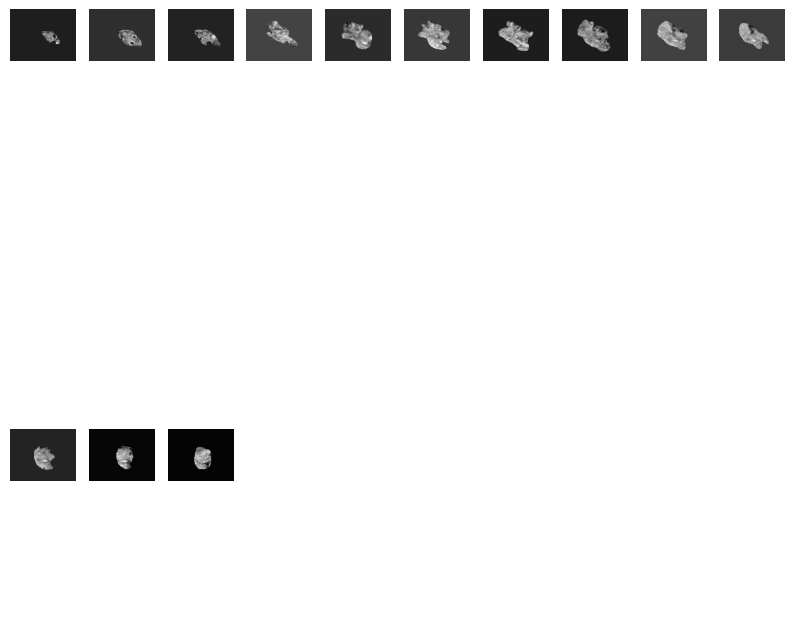

CroppedSegment shape: (13, 92, 118)


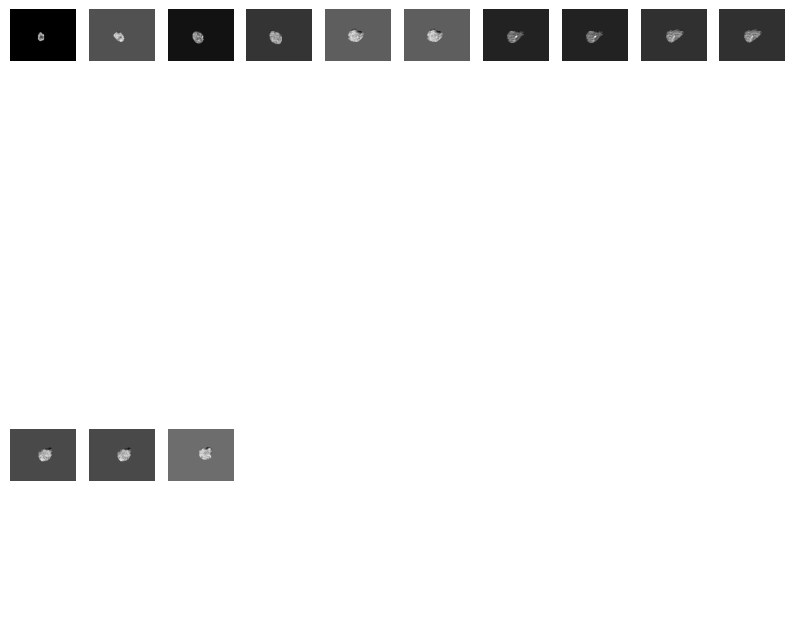

CroppedSegment shape: (13, 92, 118)


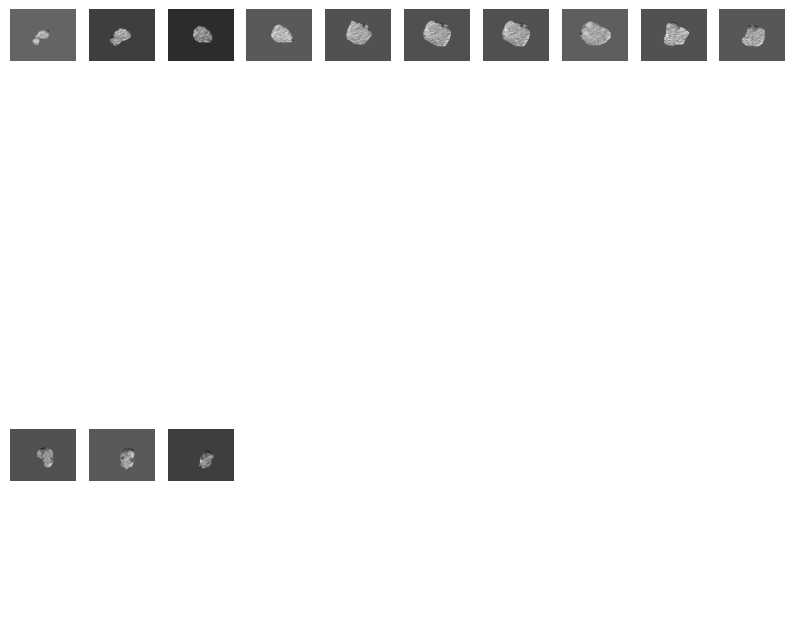

CroppedSegment shape: (13, 92, 118)


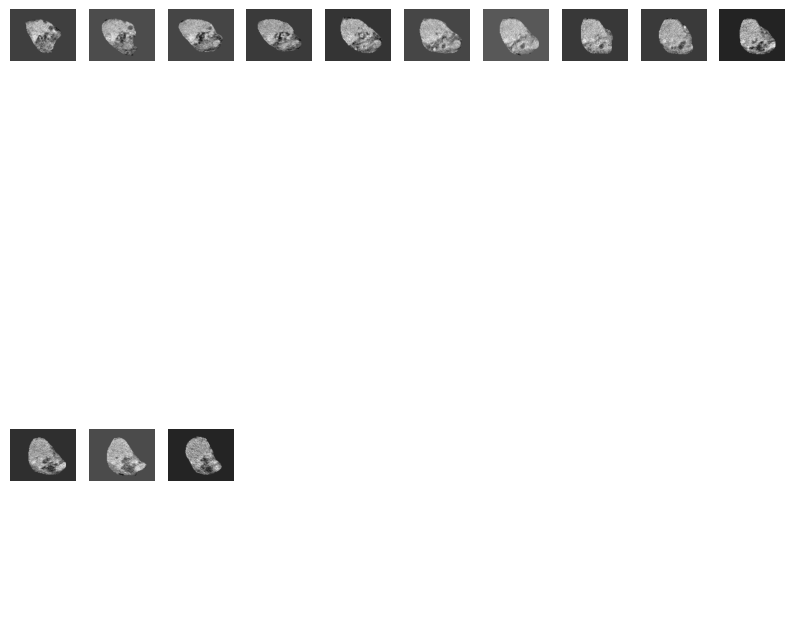

CroppedSegment shape: (13, 92, 118)


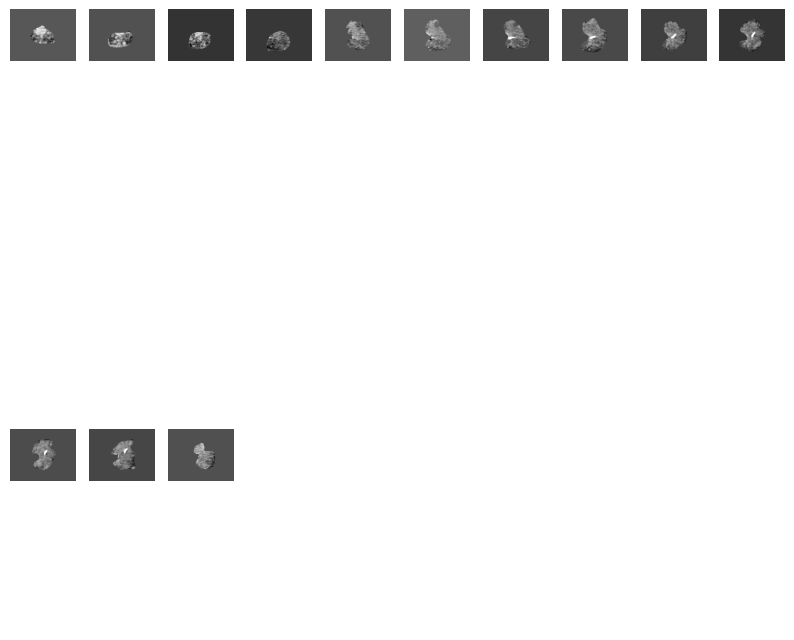

CroppedSegment shape: (13, 92, 118)


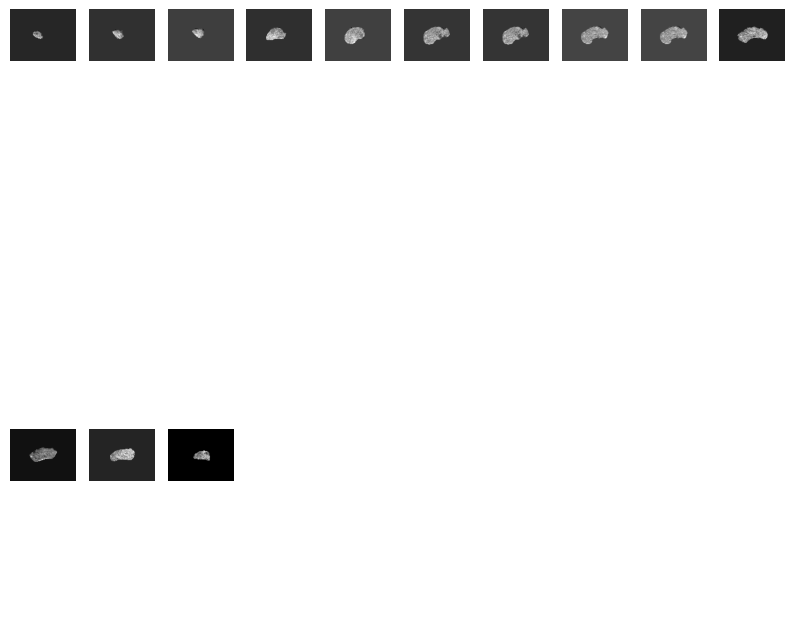

CroppedSegment shape: (13, 92, 118)


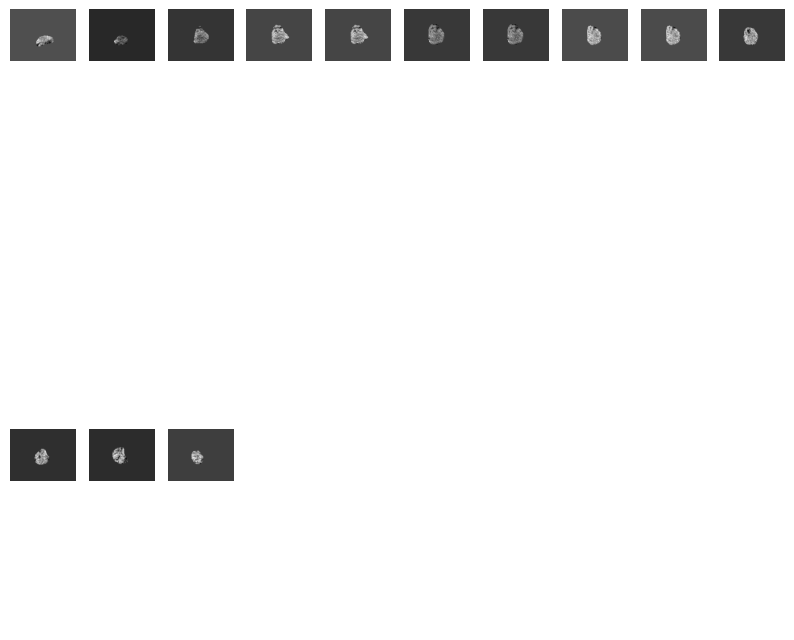

CroppedSegment shape: (13, 92, 118)


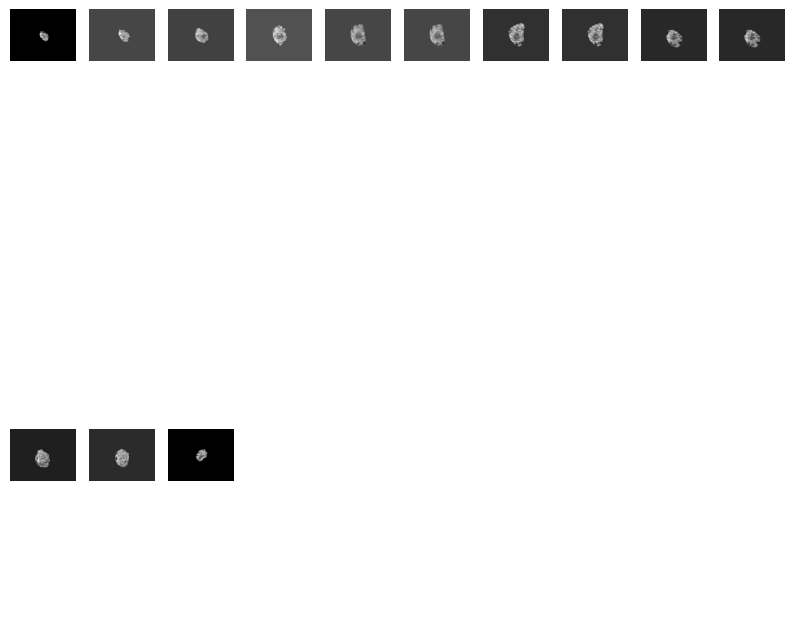

CroppedSegment shape: (13, 92, 118)


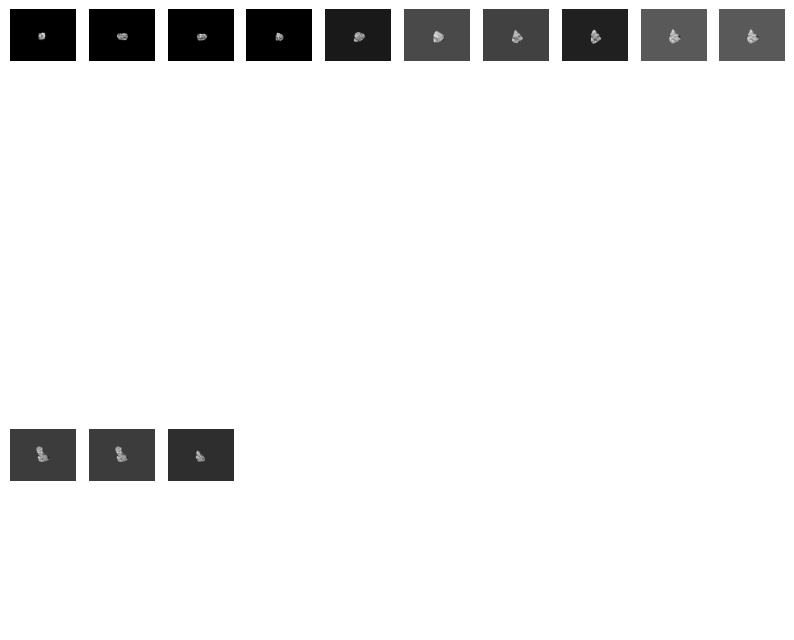

CroppedSegment shape: (13, 92, 118)


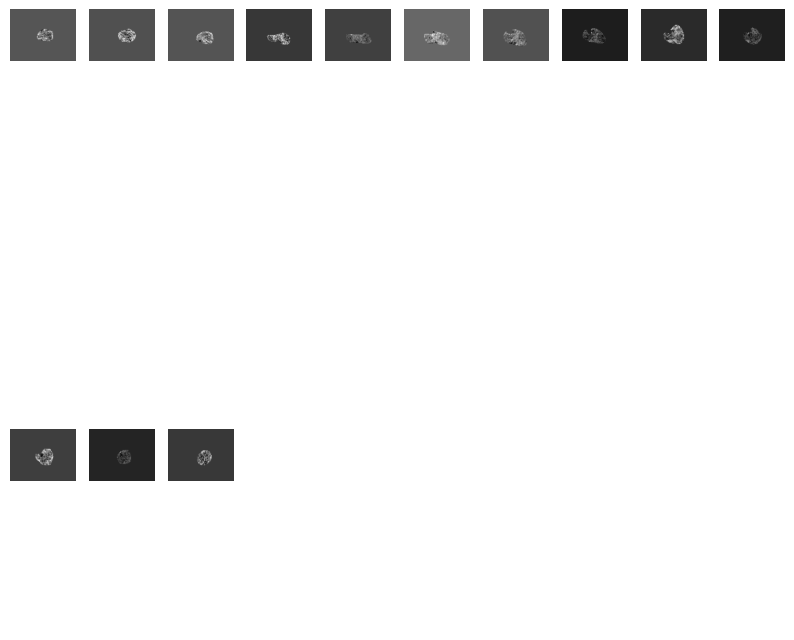

CroppedSegment shape: (13, 92, 118)


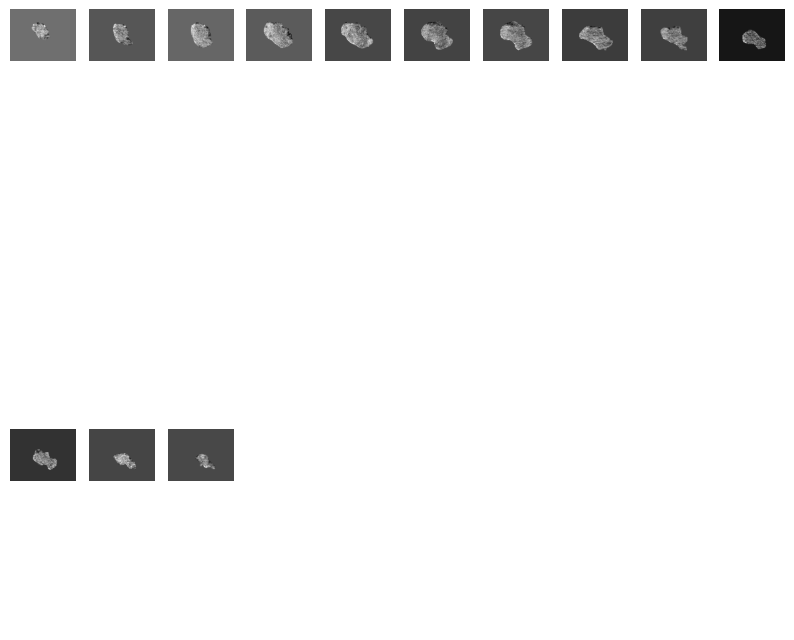

CroppedSegment shape: (13, 92, 118)


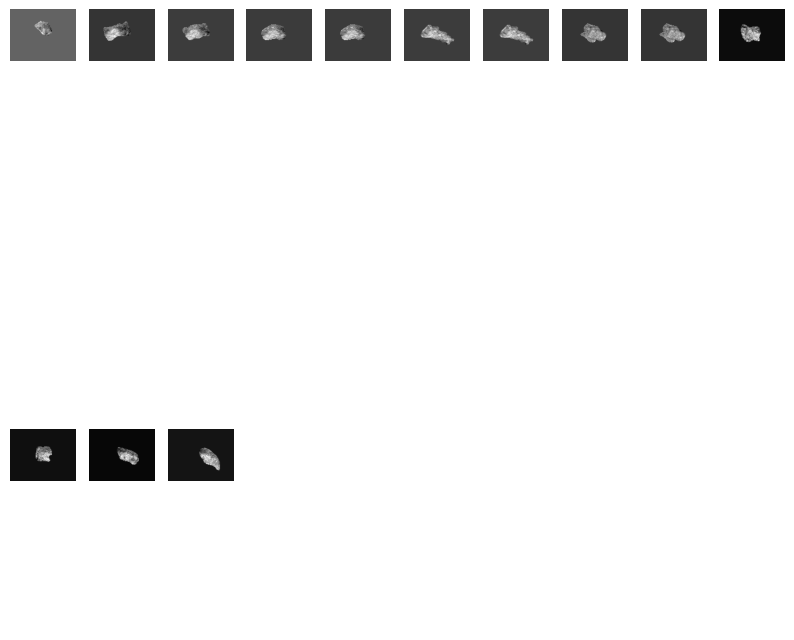

CroppedSegment shape: (13, 92, 118)


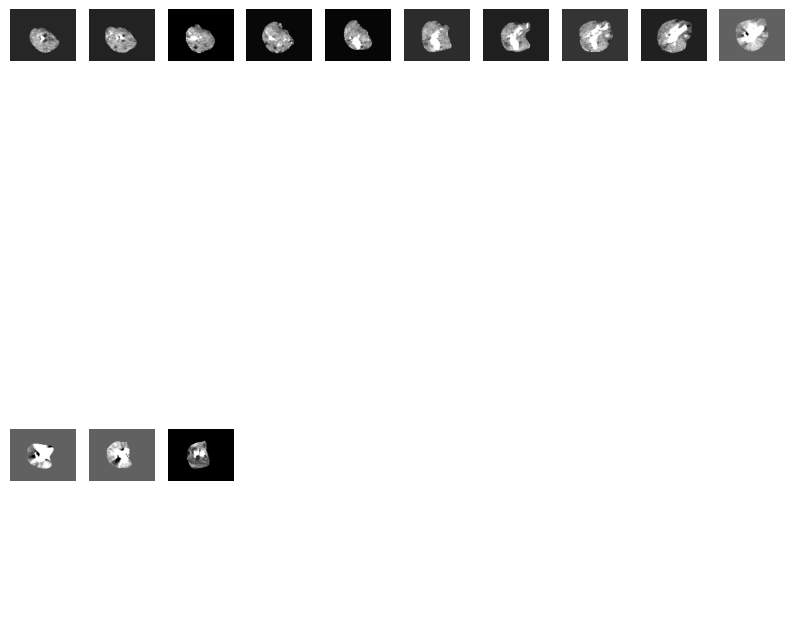

CroppedSegment shape: (13, 92, 118)


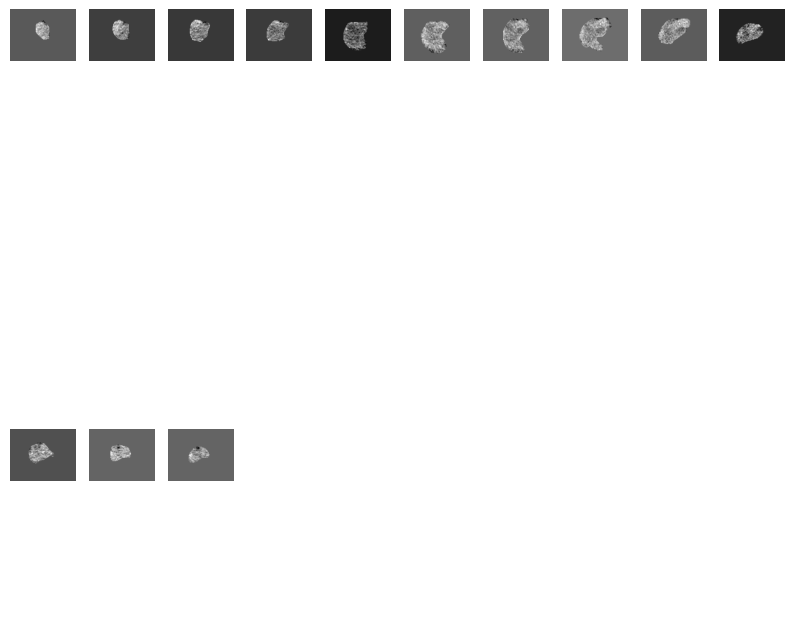

CroppedSegment shape: (13, 92, 118)


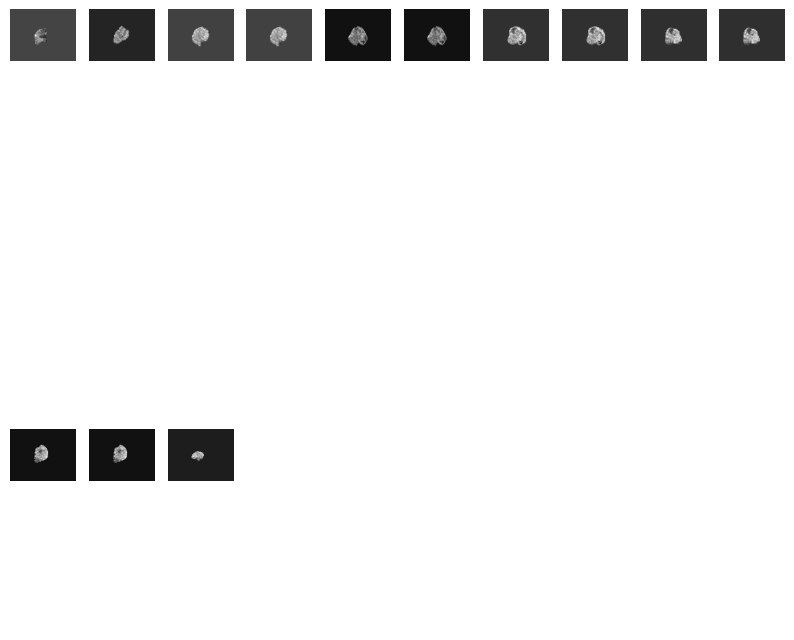

CroppedSegment shape: (13, 92, 118)


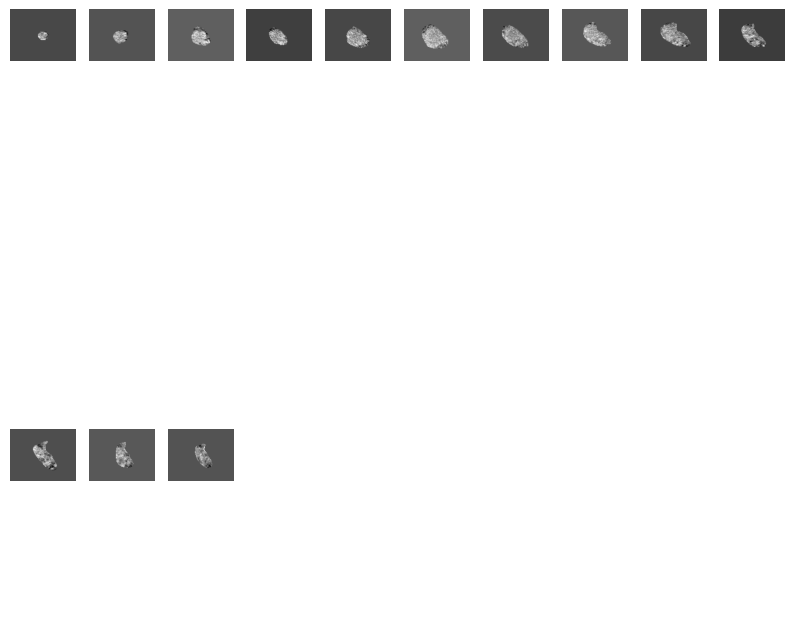

CroppedSegment shape: (13, 92, 118)


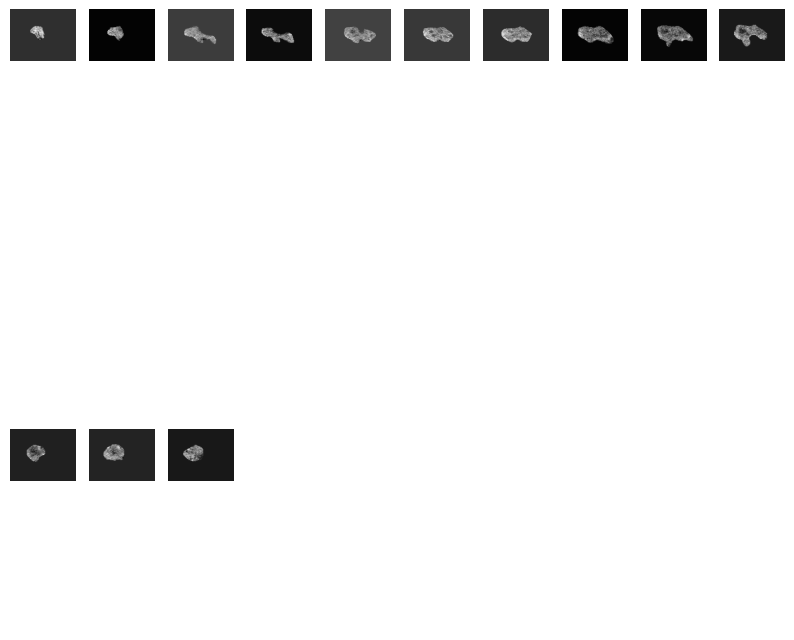

CroppedSegment shape: (13, 92, 118)


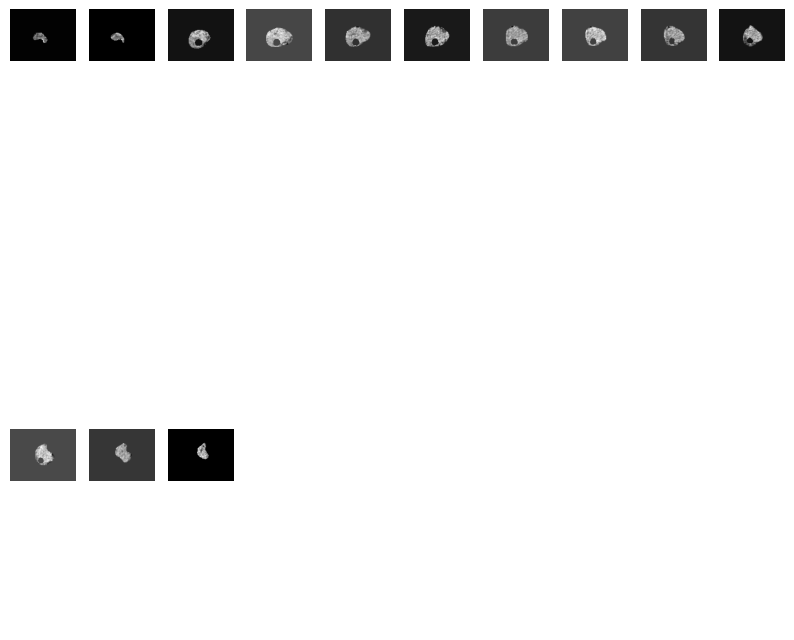

CroppedSegment shape: (13, 92, 118)


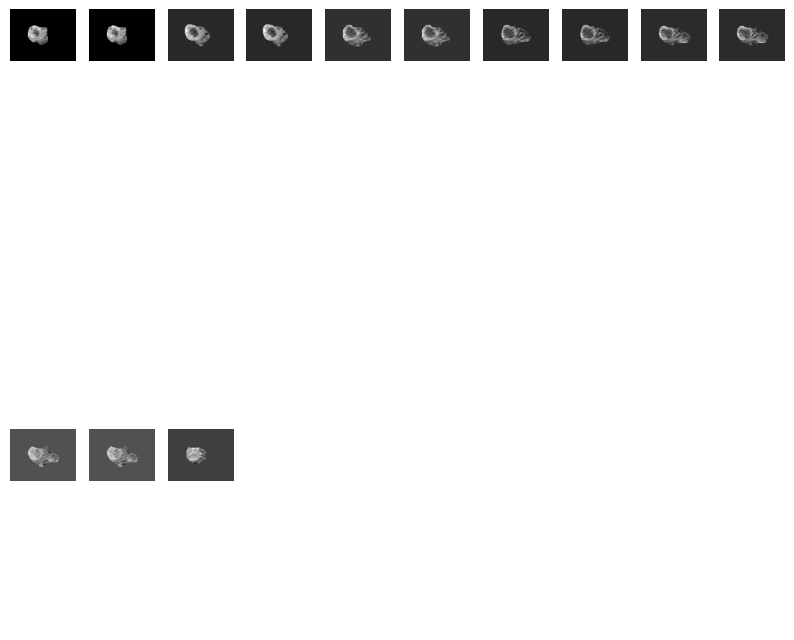

In [16]:
#Save the results of the different combinations of backgrounds and sizes

name = f'hasBackground={hasBackground}-usesLargestBox={usesLargestBox}-segmentsMultiple={segmentsMultiple}'        
croppedSegmentsList = np.load(f'preprocessCombinations/{name}.npy')


if grouped2D: #if >100 then we are doing groupings of 2D images
    temp = np.zeros((croppedSegmentsList.shape[0]*croppedSegmentsList.shape[1], croppedSegmentsList.shape[2], croppedSegmentsList.shape[3]))
    for image in range(croppedSegmentsList.shape[0]):
        for slice in range(croppedSegmentsList.shape[1]):
            temp[image*croppedSegmentsList.shape[1]+slice,:,:] = croppedSegmentsList[image,slice,:,:]
    
    croppedSegmentsList = temp
    
print('croppedSegmentsList Shape:', croppedSegmentsList.shape)   
        

In [14]:
# figure,axis = plt.subplots(1,len(croppedSegmentsList),figsize=(200,100))
# for idx in range(len(croppedSegmentsList)):        
#     axis[idx].imshow(croppedSegmentsList[idx], cmap="gray")
#     axis[idx].axis('off')
# plt.savefig('padding10.png')
# # plt.show()

# Data augmentation

In [15]:
# Getting information about the transformations
def generateTransform(RandomHorizontalFlipValue=0.5,RandomVerticalFlipValue=0.5, RandomRotationValue=50, RandomElaticTransform=[0,0], brightnessConstant=0, contrastConstant=0, kernelSize=3, sigmaRange=(0.1,1.0)):
    training_data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(degrees=RandomRotationValue),
        transforms.ElasticTransform(alpha=RandomElaticTransform[0], sigma=RandomElaticTransform[1]),
        transforms.ColorJitter(brightnessConstant, contrastConstant),
        transforms.GaussianBlur(kernel_size = kernelSize, sigma=sigmaRange),
        transforms.RandomHorizontalFlip(p=RandomHorizontalFlipValue),
        transforms.RandomVerticalFlip(p=RandomVerticalFlipValue),
        transforms.ToTensor()
    ]) 
    return training_data_transforms


def getTransformValue(transform, desiredTranform, desiredTranformValue):
    if transform==None or desiredTranform==None or desiredTranformValue==None:
      return None
    for t in transform.transforms:
        if isinstance(t, desiredTranform):
            return t.__getattribute__(desiredTranformValue)
    return None



In [16]:
# For 2D images:
# ## Working with pytorch tensors
class PatientData(Dataset):
    def __init__(self, image, classifications, transform=None):
        self.data = image
        # Convert classification to torch tensor
        temp = []
        for classification in classifications:
            convert = torch.tensor(classification, dtype=torch.int64) # casting to long
            convert = convert.type(torch.LongTensor)
            temp.append(convert)
            
        self.classification = temp
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        
        # Apply augmentations if there are any
        if self.transform:
            image = self.transform(image).type(torch.float)
        # Normalize the images post augmentation
        image = (image - torch.mean(image)) / torch.std(image)
        label = self.classification[idx]
        return image, label


def convertDataToLoaders(xTrain, yTrain, xVal, yVal, xTest, yTest, training_data_transforms = None, batchSize=8):
    ## Sample the data with 75% of the training set 
    # TrainBalancedSampler = WeightedRandomSampler(weightsForClasses, len(yTrain)//2+len(yTest)//4)
    
    # Testing data tranfrom, should be just the plain images
    testing_data_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ]) 

    # Use the same default training transform as the testing transform if not specified
    if training_data_transforms == None:
        training_data_transforms = testing_data_transforms
        
    # Convert the testing sets to data loaders
    trainingData = PatientData(xTrain, yTrain, transform=training_data_transforms)
    trainingData = DataLoader(trainingData, batch_size=batchSize, shuffle=True)#, sampler= TrainBalancedSampler)

    validationData = PatientData(xVal, yVal, transform=testing_data_transforms)
    validationData = DataLoader(validationData, batch_size=batchSize, shuffle=False)

    testingData = PatientData(xTest, yTest, transform=testing_data_transforms)
    testingData = DataLoader(testingData, batch_size=batchSize, shuffle=False)

    return trainingData, validationData, testingData, training_data_transforms


In [17]:
# # For 3D images:

# import torchio

# # ## Working with pytorch tensors
# class TorchDataset(Dataset):
#     def __init__(self, images, classifications, transform=None):
#         self.data = images
#         temp = []
#         for classification in classifications:
#             convert = torch.tensor(classification, dtype=torch.int64) # casting to long
#             convert = convert.type(torch.LongTensor)
#             temp.append(convert)
            
#         self.classification = temp
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         images = self.data[idx]
#         # Normalize the images
#         images = (images - np.min(images)) / (np.max(images) - np.min(images))


#         images = torch.from_numpy(images)
#         images = torch.FloatTensor(images)

#         # images = torch.from_numpy(images)
#         print(type(images))
        

#         label = self.classification[idx]
#         # Convert sample to a tensor
#         # sample = torch.tensor(sample, dtype=torch.float32).permute(2, 0, 1)  # Change shape to (C, H, W)

#         if self.transform:
#             images = self.transform(images)
        
#         return images, label
    

# # Set the random seed for reproducibility
# random.seed(0)
# torch.manual_seed(0) 

# ## Sample the data with 75% of the training set 
# # TrainBalancedSampler = WeightedRandomSampler(weightsForClasses, len(yTrain)//2+len(yTest)//4)

# # Define data augmentation transforms
# training_data_transforms = torchio.Compose([
#     torchio.RandomFlip(axes=('Left','Right'), flip_probability=RandomVerticalFlipProbablility),
#     torchio.RandomFlip(axes=('Anterior','Posterior'), flip_probability=RandomHorizontalFlipProbablility),
#     torchio.RandomNoise(std=(0, 0.1)),
#     torchio.RandomBlur(std=(0, 1))
# ]) 
# # testing_data_transforms = transforms.Compose([
# #     transforms.ToPILImage(),
# #     transforms.ToTensor()
# # ]) 


# # Convert the testing sets to data loaders
# trainingData = TorchDataset(xTrain, yTrain, transform=training_data_transforms)

# trainingData = DataLoader(trainingData, batch_size=batchSize, shuffle=False)#, sampler= TrainBalancedSampler)

# testingData = TorchDataset(xTest, yTest, transform=None)# testing_data_transforms)
# testingData = DataLoader(testingData, batch_size=batchSize, shuffle=False)

### Define Model and training

In [18]:
class Large2D(torch.nn.Module):
    def __init__(self, dropoutRate=0.2):
        super(Large2D, self).__init__()

        #Resnet50 as first layer
        self.resNet50 = models.resnet50(weights='IMAGENET1K_V2')
        # self.resNet50 = models.resnet50(pretrained=True)

        # Modify the first convolutional layer to accept single-channel input
        self.resNet50.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0, bias=True)

        # Freeze all layers of the resNet
        for param in self.resNet50.parameters():
            param.requires_grad = False
                
        # Hidden layers with batchnorms
        self.batchNormalization0 = nn.BatchNorm1d(self.resNet50.fc.out_features)
        self.hiddenLayer1 = nn.Linear(self.resNet50.fc.out_features, 528)
        self.batchNormalization1 = nn.BatchNorm1d(528)
        self.hiddenLayer2 = nn.Linear(528, 128)
        self.batchNormalization2 = nn.BatchNorm1d(128)
        self.hiddenLayer3 = nn.Linear(128, 64)
        self.batchNormalization3 = nn.BatchNorm1d(64)

        # Output layer
        self.outputLayer = nn.Linear(64, 3)
        self.softmax = nn.Softmax()

        #Other layers
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropoutRate)
        

    def forward(self, x):
        # Into ResNet
        x = self.resNet50(x)
        x = self.batchNormalization0(x) if x.size(dim=0)>1 else x
        x = self.relu(x)
        x = self.dropout(x)
        # Into hidden layer1
        x = self.hiddenLayer1(x) 
        x = self.batchNormalization1(x) if x.size(dim=0)>1 else x
        x = self.relu(x)
        x = self.dropout(x)
        # Into hidden layer2
        x = self.hiddenLayer2(x)
        x = self.batchNormalization2(x) if x.size(dim=0)>1 else x
        x = self.relu(x)
        x = self.dropout(x)
        # Into hidden layer3
        x = self.hiddenLayer3(x)
        x = self.batchNormalization3(x) if x.size(dim=0)>1 else x
        x = self.relu(x)
        x = self.dropout(x)
        # Output layer
        x = self.outputLayer(x)
        x = self.softmax(x)
        return x


class Small2D(torch.nn.Module):
    def __init__(self, dropoutRate=0.2):
        super(Small2D, self).__init__()

        #Resnet50 as first layer
        self.resNet50 = models.resnet50(weights='IMAGENET1K_V2')
        # self.resNet50 = models.resnet50(pretrained=True)

        # Modify the first convolutional layer to accept single-channel input
        self.resNet50.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0, bias=True)

        # Freeze all layers of the resNet
        for param in self.resNet50.parameters():
            param.requires_grad = False
                
        # Modify the final fully connected layer
        num_features = self.resNet50.fc.out_features
        self.fc = nn.Linear(num_features, 3)
        self.softMax = nn.Softmax()

    def forward(self, x):
        x = self.resNet50(x)
        x = self.fc(x)
        x = self.softMax(x)
        return x 
    
def defineModel(dropoutRate=0.2,learningRate=0.001, weight_decay=0.01, model = 'Small2D'):
    if model == 'Small2D':
        model = Small2D(dropoutRate)
    else:
        model = Large2D(dropoutRate)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learningRate, weight_decay=weight_decay)

    return model, criterion, optimizer

In [19]:
# from fmcib.models import fmcib_model

# class FoundationClassificationModel(torch.nn.Module):
#     def __init__(self, dropoutRate=0.2):
#         super(FoundationClassificationModel, self).__init__()

#         # Foundation model as first layer
#         self.foundationModel = fmcib_model()
        
#         # Modify the first convolutional layer to accept single-channel input
#         self.foundationModel.trunk.conv1 = nn.Conv3d(1, 128, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
        
#         # Freeze all layers of the foundation model
#         for param in self.foundationModel.parameters():
#             param.requires_grad = False
                
#         # Hidden layers with batchnorms
#         self.batchNormalization0 = nn.BatchNorm1d(self.foundationModel.fc.out_features)
#         self.hiddenLayer1 = nn.Linear(self.foundationModel.fc.out_features, 528)
#         self.batchNormalization1 = nn.BatchNorm1d(528)
#         self.hiddenLayer2 = nn.Linear(528, 128)
#         self.batchNormalization2 = nn.BatchNorm1d(128)
#         self.hiddenLayer3 = nn.Linear(128, 64)
#         self.batchNormalization3 = nn.BatchNorm1d(64)

#         # Output layer
#         self.outputLayer = nn.Linear(64, 3)
#         self.softmax = nn.Softmax()

#         #Other layers
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(dropoutRate)

#     def forward(self, x):
#         # Into foundation model
#         x = self.foundationModel(x)
#         x = self.batchNormalization0(x) if x.size(dim=0)>1 else x
#         x = self.relu(x)
#         x = self.dropout(x)
#         # Into hidden layer1
#         x = self.hiddenLayer1(x) 
#         x = self.batchNormalization1(x) if x.size(dim=0)>1 else x
#         x = self.relu(x)
#         x = self.dropout(x)
#         # Into hidden layer2
#         x = self.hiddenLayer2(x)
#         x = self.batchNormalization2(x) if x.size(dim=0)>1 else x
#         x = self.relu(x)
#         x = self.dropout(x)
#         # Into hidden layer3
#         x = self.hiddenLayer3(x)
#         x = self.batchNormalization3(x) if x.size(dim=0)>1 else x
#         x = self.relu(x)
#         x = self.dropout(x)
#         # Output layer
#         x = self.outputLayer(x)
#         x = self.softmax(x)
#         return x

In [20]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


class EarlyStopping:
    def __init__(self, patience=5, minDelta=0):
        self.patience = patience
        self.minDelta = minDelta
        self.counter = 0
        self.minValLoss = float('inf')
        
    def earlyStoppingCheck(self, currValLoss):
        if np.isnan(currValLoss):
            return True
        if currValLoss < self.minValLoss:
            self.minValLoss = currValLoss
            self.counter = 0
        elif currValLoss > self.minValLoss + self.minDelta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)

            predictions.append(predicted)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, predictions


In [21]:
def trainModel(model, criterion, optimizer, trainingData, validationData, numOfEpochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using this device:', device)
    #Send the model to the same device that the tensors are on
    model.to(device)

    earlyStopping = EarlyStopping(patience=10, minDelta=0)
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    for epoch in range(numOfEpochs):
        #Train model
        curTrainLoss, curTrainAcc = train(model, trainingData, criterion, optimizer, device)    
        print(f"Epoch {epoch+1}/{numOfEpochs}")
        print(f"Train Loss: {curTrainLoss:.4f}, Train Acc: {curTrainAcc:.4f}")
        #Evaluate on validation set
        curValLoss, curValAcc, _ = evaluate(model, validationData, criterion, device)    
        print(f"Val Loss: {curValLoss:.4f}, Val Acc: {curValAcc:.4f}")

        #Append metrics to lists
        train_loss.append(curTrainLoss)
        train_acc.append(curTrainAcc)
        val_loss.append(curValLoss)
        val_acc.append(curValAcc)

        #Check for early stopping conditions
        if earlyStopping.earlyStoppingCheck(curValLoss):
            print(f'Early stopping - Val loss has not decreased in {earlyStopping.patience} epochs. Terminating training at epoch {epoch+1}.')
            break

    history = {'train_loss':train_loss, 'train_acc':train_acc, 'val_loss':val_loss, 'val_acc':val_acc}
    return model, criterion, device, history, epoch


In [22]:
# def read_history_from_pickle(testPathName):
#     with open(testPathName+'/history.pkl', 'rb') as fp:
#         history = pickle.load(fp)
#     return history

# #Read history
# history = read_history_from_pickle(testPathName)

# # Load and evalaute the model
# modelWeightPath = testPathName+'/model.pt'
# model = ResNet50ClassificaitonModel()
# model.load_state_dict(torch.load(modelWeightPath))

#Send the model to the device used
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using this device:', device)
# #Send the model to the same device that the tensors are on
# model.to(device)



### Save results


In [23]:
# Save the contents of this test

def saveResults(testPathName, model, history, training_data_transforms, saveModel=True):
    os.makedirs(testPathName, exist_ok=True)

    #Save history as pickle
    with open(testPathName+'/history.pkl', 'wb') as fp:
        pickle.dump(history, fp)

    # Save weigths of model
    if saveModel:
        torch.save(model.state_dict(), testPathName+'/model.pt')

    #Save notebooks and scripts
    # if os.path.exists('imageSegmentationMultipleSingleSlice.py'):
    #     shutil.copy('imageSegmentationMultipleSingleSlice.py',testPathName+'/convertedScript.py')
    # if os.path.exists('imageSegmentationMultipleSingleSlice.ipynb'):
    #     shutil.copy('imageSegmentationMultipleSingleSlice.ipynb',testPathName+'/notebook.ipynb')

    # Save transformations for easy access
    f = open(testPathName + '/training_data_transforms.txt', 'w')
            
    for line in training_data_transforms.__str__():
        f.write(line)
    f.close()



### Evaluate performance on the testing set

In [24]:
def convertTensorToPredictions(tensorList, dictionary):
        """Converts a list of tensors into a single list and then feeds those values into a given dictionary."""
        values = []
        for batch in tensorList:
            batchValues = batch.tolist()        
            values+= batchValues
        for value in values:
            dictionary[value]+=1
        return values, dictionary

def evaluateModelOnTestSet(testPathName, model, testingData, criterion, device, saveConfusionMatrix = True, showConfusionMatrix=True):
    test_loss, test_acc, predictions = evaluate(model, testingData, criterion, device)

    predicts, predictsTotal = convertTensorToPredictions(predictions, {0:0,1:0,2:0})

    originalLabels = [label.to(device) for image, label in testingData]
    ans, ansTotal = convertTensorToPredictions( originalLabels, {0:0,1:0,2:0})

    # Test metrics
    print('---------------------------------------\nTesting Metrics')
    accuracy = accuracy_score(ans, predicts)
    f1 = f1_score(ans, predicts, average='weighted')  # Use 'weighted' for multiclass classification
    recall = recall_score(ans, predicts, average='weighted')  # Use 'weighted' for multiclass classification

    testingMetrics = {'Evaluation accuracy': test_acc, 'Predictions split': predictsTotal, 'Answers split': ansTotal, 'Predictions': predicts, 'Answers    ': ans,  'Accuracy':accuracy, 'F1 Score':f1, 'Recall':recall}

    file = open(testPathName+'/testingMetrics.txt','w')
    for key, value in testingMetrics.items():
        file.write(f'{key}: {value}\n')
    file.close()

    for key, value in testingMetrics.items():
        print(f'{key}: {value}')


    print('---------------------------------------\nConfusion Matrix:')
    # Confusion Matrix
    result = confusion_matrix(ans,predicts,normalize='pred')
    disp = ConfusionMatrixDisplay(result)
    
    if saveConfusionMatrix:
        plt.savefig(testPathName+'/confusion_matrix.png')
    
    if showConfusionMatrix:
        plt.show()

    plt.clf() 
    return disp, accuracy, f1, recall, predictsTotal 

### View Performance on Training Set

In [25]:
def plotTraining(testPathName, testName, history, saveFigure=True, showResult=True):
    plt.style.use('default')
    
    figure, ax = plt.subplots( 1, 2, figsize=(20, 10))
    # plt.suptitle('Accuracy', fontsize=10)
    ax[0].set_title("Loss")
    ax[0].set_ylabel('Loss', fontsize=16)
    ax[0].set_xlabel('Epoch', fontsize=16)
    ax[0].plot(history['train_loss'], label='Training Loss')
    ax[0].plot(history['val_loss'], label='Validation Loss')
    ax[0].legend(loc='upper right')

    ax[1].set_title("Accuracy")
    ax[1].set_ylabel('Accuracy', fontsize=16)
    ax[1].set_xlabel('Epoch', fontsize=16)
    
    ax[1].plot(history['train_acc'], label='Training Accuracy')
    ax[1].plot(history['val_acc'], label='Validation Accuracy')
    ax[1].legend(loc='lower right')

    if saveFigure:
        plt.savefig(testPathName+'/training_history.png')
    
    if showResult:
        plt.show()

    plt.clf() 

    return figure


def plotTrainingPerformances(testPathName, testName, histories, saveFigure=True, showResult=True):
    plt.style.use('default')

    figure, ax = plt.subplots( 2, len(histories), figsize=(80, 20))
    for idx, history in enumerate(histories):
        # plt.suptitle('Accuracy', fontsize=10)
        ax[0][idx].set_title("Loss")
        ax[0][idx].set_ylabel('Loss', fontsize=16)
        ax[0][idx].set_xlabel('Epoch', fontsize=16)
        ax[0][idx].plot(history['train_loss'], label='Training Loss')
        ax[0][idx].plot(history['val_loss'], label='Validation Loss')
        ax[0][idx].legend(loc='upper right')

        ax[1][idx].set_title("Accuracy")
        ax[1][idx].set_ylabel('Accuracy', fontsize=16)
        ax[1][idx].set_xlabel('Epoch', fontsize=16)
        ax[1][idx].plot(history['train_acc'], label='Training Accuracy')
        ax[1][idx].plot(history['val_acc'], label='Validation Accuracy')
        ax[1][idx].legend(loc='lower right')

    plt.suptitle(f'{testName} \nTrainining Performance', fontsize=30)


    if saveFigure:
        plt.savefig(testPathName+'/training_history.png')
    
    if showResult:
        plt.show()

    plt.clf() 

    return figure

## Run FullStack of Model

In [26]:
def plotConfusionMatricies(testPathName, testName, confusion_matricies):
    figure,axis = plt.subplots(1,len(confusion_matricies),figsize=(20, 5))
    for idx in range(len(confusion_matricies)):        
        confusion_matricies[idx].plot(ax=axis[idx])
        confusion_matricies[idx].im_.colorbar.remove()

    figure.suptitle(f'{testName}\nConfusion Matricies')
    plt.savefig(testPathName+'/confusion_matrix.png')
    plt.show()
    plt.clf() 
    
def meanConfidenceInterval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)

    min = np.min(a)
    max = np.max(a)

    return [m, h, [min, max], data]

def averagePredictionTotals(predictions, numberOfTrials=5):
    average = {0:0,1:0,2:0}
    for prediction in predictions:
        for key, value in prediction.items():
            average[key] += value
    
    for key,value in average.items():
        average[key] = value/numberOfTrials

    return average

#Runs all model evaluations steps
def runModelFullStack(testPathName, testName, xTrain, yTrain, xVal, yVal, xTest, yTest, modelInformation, trainingTransform=None):
    # modelInformation = { 'learningRate': learningRate, 'dropoutRate': dropoutRate, 'batchSize': batchSize, 'numOfEpochs': numOfEpochs, 'weight_decay':weight_decay}
    trainingData, validationData, testingData, training_data_transforms = convertDataToLoaders(xTrain, yTrain, xVal, yVal, xTest, yTest, training_data_transforms = trainingTransform, batchSize=modelInformation['batchSize'])
    model, criterion, optimizer = defineModel(dropoutRate=modelInformation['dropoutRate'], learningRate = modelInformation['learningRate'], weight_decay=modelInformation['weight_decay'], model = modelInformation['model'])
    model, criterion, device, history, endingEpoch = trainModel(model, criterion, optimizer, trainingData,validationData, numOfEpochs=modelInformation['numOfEpochs'])
    saveResults(testPathName, model, history, training_data_transforms, saveModel=False)
    confusionMatrix, accuracy, f1, recall, predictsTotal = evaluateModelOnTestSet(testPathName, model, testingData, criterion, device, saveConfusionMatrix = False, showConfusionMatrix=False)
    # plotTraining(testPathName, testName, history, saveFigure=True, showResult=True)

    return confusionMatrix, history, accuracy, f1, recall, predictsTotal, endingEpoch+1


In [30]:
def addEvalDetailToModel(evalDetailLine, dataframe):
    dataframe.loc[dataframe.shape[0]] = [evalDetailLine] + ['']*(len(dataframe.columns)-1)
    
def appendMetricsToXLSX(testPathName, trainingTransform, accuracyInformation, f1Information, recallInformation, predictsTotal, endingEpochs, modelInformation, dataframe):
    rotation = getTransformValue(trainingTransform, desiredTranform=transforms.RandomRotation, desiredTranformValue='degrees')
    elasticTransform = [getTransformValue(trainingTransform, desiredTranform=transforms.ElasticTransform, desiredTranformValue='alpha'), getTransformValue(trainingTransform, desiredTranform=transforms.ElasticTransform, desiredTranformValue='sigma')]
    brightness = getTransformValue(trainingTransform, desiredTranform=transforms.ColorJitter, desiredTranformValue='brightness')
    contrast = getTransformValue(trainingTransform, desiredTranform=transforms.ColorJitter, desiredTranformValue='contrast')
    guassianBlur = [ getTransformValue(trainingTransform, desiredTranform=transforms.GaussianBlur, desiredTranformValue='kernel_size'), getTransformValue(trainingTransform, desiredTranform=transforms.GaussianBlur, desiredTranformValue='sigma')]
    randomHorizontalFlip = getTransformValue(trainingTransform, desiredTranform=transforms.RandomHorizontalFlip, desiredTranformValue='p')
    randomVerticalFlip = getTransformValue(trainingTransform, desiredTranform=transforms.RandomVerticalFlip, desiredTranformValue='p')
    
    exportValue = [testPathName, modelInformation['numOfEpochs'],modelInformation['batchSize'], modelInformation['learningRate'],modelInformation['dropoutRate'],modelInformation['weight_decay'],modelInformation['commandRan'], \
        rotation, elasticTransform, brightness, contrast, guassianBlur, randomHorizontalFlip, randomVerticalFlip, predictsTotal, \
            accuracyInformation[0], f1Information[0], recallInformation[0], \
            accuracyInformation[1], f1Information[1],  recallInformation[1], \
            accuracyInformation[3], f1Information[3], recallInformation[3], \
            endingEpochs]

    dataframe.loc[dataframe.shape[0]] = exportValue + ['']*(len(dataframe.columns)-len(exportValue))
    
def generateKFoldsValidation(identifier,identifierValue, modelInformation, grouped2D, k=5,trainingTransform=None):

    # Set the random seed for reproducibility
    random.seed(0)
    torch.manual_seed(0) 
    
    #Keep history of values
    confusion_matricies = []
    histories = []
    accuracies = []
    f1s = []
    recalls = []
    predictionSplits = []
    endingEpochs = []

    # run datasplit with stratified kfolds:
    
    if grouped2D: #if >100 then we are doing groupings of 2D images
        stratifiedGroupFolds = StratifiedGroupKFold(n_splits=k, shuffle=True, random_state=42)
        stratifiedGroupFolds.get_n_splits(croppedSegmentsList, recistCriteria)
        splits = enumerate(stratifiedGroupFolds.split(croppedSegmentsList, recistCriteria, cases))
        
    else:
        stratifiedFolds = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        stratifiedFolds.get_n_splits(croppedSegmentsList, recistCriteria)
        splits = enumerate(stratifiedFolds.split(croppedSegmentsList, recistCriteria))
        
    for i, (train_index, test_index) in splits:
        
        #Set the name of the test
        testName = f'{identifier}-{identifierValue}'
        
        testPathName = 'Tests/'+testName+f'/foldn{i+1}'
        print(f'{identifier}: foldn{i+1} RUN\n=========================================')
        xTest, yTest = [croppedSegmentsList[i] for i in test_index], [recistCriteria[i] for i in test_index]
        xTrain, yTrain = [croppedSegmentsList[i] for i in train_index], [recistCriteria[i] for i in train_index]
        xVal, yVal = xTest, yTest # Set the validation set to the same as the testing set
        #xVal, yVal = [croppedSegmentsList[i] for i in train_index[:len(xTest)]], [recistCriteria[i] for i in train_index[:len(yTest)]]
        


        # Convert the recist criteria to 0,1,2
        yTrain = [x-1 for x in yTrain]
        yVal = [x-1 for x in yVal]
        yTest = [x-1 for x in yTest]

        # ## Working with Numpy arrays
        xTrain = np.array(xTrain) 
        xTest = np.array(xTest)
        xVal = np.array(xVal)
        yTrain = np.array(yTrain)
        yVal = np.array(yVal)
        yTest = np.array(yTest)

        xTrain = np.expand_dims(xTrain,axis=-1)
        xVal = np.expand_dims(xVal,axis=-1)
        xTest = np.expand_dims(xTest,axis=-1)

        # Get and save results for each fold        
        confusionMatrix, history, accuracy, f1, recall, predictsTotal, endingEpoch = runModelFullStack(testPathName, testName, xTrain, yTrain, xVal, yVal, xTest, yTest, trainingTransform=trainingTransform, modelInformation=modelInformation) 

        confusion_matricies.append(confusionMatrix)
        histories.append(history)
        accuracies.append(accuracy)
        f1s.append(f1)
        recalls.append(recall)
        predictionSplits.append(predictsTotal)
        endingEpochs.append(endingEpoch)
        print('\n\n')



    # Calculate the average of the metrics for the kfolds of this transformation and save it
    kFoldsTestMetrics = {'Prediction averages': averagePredictionTotals(predictionSplits), 'Accuracy':meanConfidenceInterval(accuracies), 'F1 Score':meanConfidenceInterval(f1s), 'Recall':meanConfidenceInterval(recalls)}
    file = open('Tests/'+testName+'/kFoldsTestMetrics.txt','w')
    for key, value in kFoldsTestMetrics.items():
        file.write(f'{key}: {value}\n')
        print(f'{key}: {value}')
    file.close()

    # Plot training and confusion matrix for each fold as a single .png
    plotConfusionMatricies('Tests/'+testName, testName, confusion_matricies)
    plotTrainingPerformances('Tests/'+testName, testName, histories, saveFigure=True, showResult=True)

    
    # Append results to the xlsx file
    appendMetricsToXLSX(testPathName, trainingTransform, meanConfidenceInterval(accuracies), meanConfidenceInterval(f1s), meanConfidenceInterval(recalls), averagePredictionTotals(predictionSplits), endingEpochs, modelInformation, dataframe)

In [93]:
# # View what the splits are for the models, the test set is {0: 4, 1: 7-8, 2: 6-5}
# stratifiedFolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# stratifiedFolds.get_n_splits(croppedSegmentsList, recistCriteria)
# for i, (train_index, test_index) in enumerate(stratifiedFolds.split(croppedSegmentsList, recistCriteria)):
#         xTrain, xTest = [croppedSegmentsList[i] for i in train_index], [croppedSegmentsList[i] for i in test_index]
#         yTrain, yTest = [recistCriteria[i] for i in train_index], [recistCriteria[i] for i in test_index]

#         # Convert the recist criteria to 0,1,2
#         yTrain = [x-1 for x in yTrain]
#         yTest = [x-1 for x in yTest]

#         #count the categorization splits of the train and test set
#         trainRecistSplit = {y: yTrain.count(y) for y in yTrain}
#         testRecistSplit = {y: yTest.count(y) for y in yTest}

#         # Format the splits nicely into an ordered dictionary
#         myKeys = list(trainRecistSplit.keys())
#         myKeys.sort()
#         trainRecistSplitDisplay = {i: trainRecistSplit[i] for i in myKeys}
#         myKeys = list(testRecistSplit.keys())
#         myKeys.sort()
#         testRecistSplitDisplay = {i: testRecistSplit[i] for i in myKeys}

#         print(f'train recist category split: {trainRecistSplitDisplay}')
#         print(f'test recist category split: {testRecistSplitDisplay}')

#         # ## Working with Numpy arrays
#         xTrain = np.array(xTrain) 
#         xTest = np.array(xTest)
#         yTrain = np.array(yTrain)
#         yTest = np.array(yTest)
#         xTrain =  np.expand_dims(xTrain,axis=-1)
#         xTest =  np.expand_dims(xTest,axis=-1)

train recist category split: {0: 16, 1: 29, 2: 23}
test recist category split: {0: 4, 1: 8, 2: 5}
train recist category split: {0: 16, 1: 29, 2: 23}
test recist category split: {0: 4, 1: 8, 2: 5}
train recist category split: {0: 16, 1: 30, 2: 22}
test recist category split: {0: 4, 1: 7, 2: 6}
train recist category split: {0: 16, 1: 30, 2: 22}
test recist category split: {0: 4, 1: 7, 2: 6}
train recist category split: {0: 16, 1: 30, 2: 22}
test recist category split: {0: 4, 1: 7, 2: 6}


In [31]:
# Data augmentations

# Balance the classes used in the model
# class1Percentage = (0.3333/16)
# class2Percentage = (0.3333/30)
# class3Percentage = (0.3333/24)

# weightsForClasses = [class1Percentage / (class1Percentage+class2Percentage+class3Percentage) , class3Percentage / (class1Percentage+class2Percentage+class3Percentage), class3Percentage / (class1Percentage+class2Percentage+class3Percentage)]

# windowLower = 40-350/2
# windowUpper = 40+350/2 

#Make all transforms that I am going to test:
transformsTested = {
    "0":None
    # "20":generateTransform(RandomRotationValue=20, RandomElaticTransform=[20,2], brightnessConstant=20, contrastConstant=20, kernelSize=3, sigmaRange=(0.001,0.4)),
    # "40":generateTransform(RandomRotationValue=40, RandomElaticTransform=[40,4], brightnessConstant=40, contrastConstant=40, kernelSize=3, sigmaRange=(0.001,0.8)),
    # "60":generateTransform(RandomRotationValue=60, RandomElaticTransform=[60,6], brightnessConstant=60, contrastConstant=60, kernelSize=3, sigmaRange=(0.001,1.2)),
    # "80":generateTransform(RandomRotationValue=80, RandomElaticTransform=[80,8], brightnessConstant=80, contrastConstant=80, kernelSize=3, sigmaRange=(0.001,1.6)),
    # "100":generateTransform(RandomRotationValue=100, RandomElaticTransform=[100,10], brightnessConstant=100, contrastConstant=100, kernelSize=3, sigmaRange=(0.001,2.0))    
}


## Open the dataframe and add the evaluation details
dataframePath='testResults.xlsx'
columns = ['name','numOfEpochs','batchSize','learningRate','dropoutRate','weight_decay', 'commandRan','RandomRotation','ElasticTransform','Brightness','Contrast','GaussianBlur','RandomHorizontalFlip','RandomVerticalFlip','PredictionAverage',
            'AccuracyAverage','F1Average', 'RecallAverage','AccuracySTD','F1STD','RecallSTD','AccuracyData','F1Data','RecallData', 'EndingEpoch']
dataframe = pd.read_excel('testResults.xlsx', header=None, names=columns)
addEvalDetailToModel(evalDetailLine, dataframe)



# python testSamples24-7.py -batchSize=8 -epochs=100 -lr=0.001 -evalDetailLine='no background tumor boxes adamw' -hasBackground=f -usesLargestBox=f -segmentsMultiple=1 -dropoutRate=0.2 -grouped2D=f &&

# python testSamples24-7.py -batchSize=8 -epochs=100 -lr=0.001 -evalDetailLine='background global boxes adamw' -hasBackground=t -usesLargestBox=t -segmentsMultiple=1 -dropoutRate=0.2 -grouped2D=f &&

# python testSamples24-7.py -batchSize=8 -epochs=100 -lr=0.001 -evalDetailLine='background tumor boxes adamw' -hasBackground=t -usesLargestBox=f -segmentsMultiple=1 -dropoutRate=0.2 -grouped2D=f &&

# python testSamples24-7.py -batchSize=8 -epochs=100 -lr=0.001 -evalDetailLine='no background global boxes adamw' -hasBackground=f -usesLargestBox=t -segmentsMultiple=1 -dropoutRate=0.2 -grouped2D=f &&

# Generate the command ran for the test 
commandRan = 'python'
for details in sys.argv:
    if 'evalDetailLine' or 'modelChosen' in details:
        detailArray = details.split('=') 
        details = f'{detailArray[0]}=\'{detailArray[1]}\''
    commandRan += f' {details}'   
print(commandRan)

modelInformation = { 'learningRate': learningRate, 'dropoutRate': dropoutRate, 'batchSize': batchSize, 'numOfEpochs':numOfEpochs, 'weight_decay':weight_decay, 'commandRan': commandRan, 'model': modelChosen}

# Run the tests
for key, value in transformsTested.items():
    generateKFoldsValidation(key,"-", k=5,trainingTransform=value, modelInformation = modelInformation, grouped2D=grouped2D)

dataframe.to_excel(dataframePath, index=False, header=False)

d:\SimpsonLab\researchpip\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\SimpsonLab\researchpip\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using this device: cuda


d:\SimpsonLab\researchpip\lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1/100
Train Loss: 1.0833, Train Acc: 0.3997
Val Loss: 1.1031, Val Acc: 0.4118
Epoch 2/100
Train Loss: 1.0462, Train Acc: 0.5068
Val Loss: 1.1056, Val Acc: 0.4072
Epoch 3/100
Train Loss: 1.0383, Train Acc: 0.5053
Val Loss: 1.1048, Val Acc: 0.4118
Epoch 4/100
Train Loss: 1.0315, Train Acc: 0.5083
Val Loss: 1.1124, Val Acc: 0.4118
Epoch 5/100
Train Loss: 1.0308, Train Acc: 0.5083
Val Loss: 1.1094, Val Acc: 0.4118
Epoch 6/100
Train Loss: 1.0265, Train Acc: 0.5113
Val Loss: 1.1152, Val Acc: 0.4118
Epoch 7/100
Train Loss: 1.0346, Train Acc: 0.5128
Val Loss: 1.1168, Val Acc: 0.4118


KeyboardInterrupt: 